Strong effort at a particle filtering rollout, where we use a trained model and try to predict an autoregressive rollout in order to do a good job.

I then apply a particle filtering approach to select only my favourite samples to see if I can produce a good rollout.

Really make sure this works.

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# hack to go a couple of directories up if we need to import from python files in some parent directory.

import os
import sys

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import pandas as pd
import json
from pathlib import Path

import torch
import torch.fft as fft
import matplotlib.pyplot as plt

import xarray as xr

import seaborn as sns
from mpl_toolkits.basemap import Basemap
import cv2

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from tqdm.auto import tqdm
import matplotlib.cm as cm

import scipy.stats as stats
from scipy.interpolate import griddata

import climatem.climate_dataset_explore_ensembles as climate_dataset
from climatem.climate_data_loader_explore_ensembles import CausalClimateDataModule
from climatem.metrics import edge_errors, mcc_latent, precision_recall, shd, w_mae
from climatem.model.tsdcd_latent_explore import LatentTSDCD
#from climatem.train_latent_constrain_graph_multigpu_pf import TrainingLatent

# import all the necessary mean squared error functions and so on
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [4]:
# Plotting functions for videos of the rollouts.

def plot_preds_icosa_robin(data, coordinates, axs, timestep, out_dir, show_plot=True):

    axs.set_global()
    axs.coastlines()
    # Add some map features for context
    axs.add_feature(cfeature.BORDERS, linestyle=':')
    axs.add_feature(cfeature.COASTLINE)
    axs.add_feature(cfeature.LAND, edgecolor='black')
    axs.gridlines(draw_labels=False)

    # Unpack coordinates for vectorized scatter plot
    x = coordinates[:, 0]
    y = coordinates[:, 1]

    # Vectorized scatter plot with color array
    s = axs.scatter(x=x, y=y, c=data, alpha=1, s=30, vmin=-3.5, vmax=3.5, cmap="RdBu_r", transform=ccrs.PlateCarree())  # Store scatter plot object

    # add a colorbar
    plt.colorbar(s, ax=axs, label="Normalised anomaly", orientation="vertical", shrink=1.0) # adjust shrink
    #axs.colorbar(s, ax=axs, label="Normalised slp", orientation="vertical", shrink=1.0) # adjust shrink

    # add a title
    plt.title(f"Timestep {timestep} of model autoregressive rollout (months)")
    
    fname = f"{out_dir}/just_icosa_pred_timestep_{timestep}.png"
    #plt.suptitle(f"Plot of timestep {timestep}")    
    plt.savefig(fname)

    if show_plot == False:
        plt.close()

    #plt.close()

def plot_preds_icosa_robin_video_array(each_timestep, coordinates:np.ndarray, out_dir:str, fname:str, show_plot:bool = True):
    '''
    Plotting global maps of the predictions using the Robinson projection.
    We use the plot_preds_icosa_robin function.
    '''
    img_array = []
    for timestep in range(len(each_timestep)):
        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(12, 6))
        plot_preds_icosa_robin(each_timestep[timestep, 88, 0, :], coordinates, ax, timestep, "plots", show_plot=show_plot)
        filename = f"{out_dir}/just_icosa_pred_timestep_{timestep}.png"
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)
        # add a title to the plot
        ax.set_title(f'Autoregressive rollout, timestep {timestep}')
        # add a colorbar
        
    print('Done plotting all samples.')

    out = cv2.VideoWriter(f'{out_dir}/{fname}.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 3, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()


In [5]:
# Read the coordinates too...

coordinates = np.loadtxt("/home/mila/j/julien.boussard/causal_model/icosahedral/mappings/vertex_lonlat_mapping.txt")
coordinates = coordinates[:, 1:]

# Load up and try to use a saved model

In [6]:

home_dir_path = Path("/home/mila/j/julien.boussard")

local_folder = home_dir_path / "causal_model" # Where code + small data is stored
scratch_dir = home_dir_path / "scratch" # Where large data is stored
results_dir = scratch_dir / "results"
os.makedirs(results_dir, exist_ok=True)
climateem_repo = local_folder / "climatem"

coordinates_path =  local_folder / "icosahedral/mappings/vertex_lonlat_mapping.txt"

coordinates = np.loadtxt(coordinates_path)
coordinates = coordinates[:, 1:]

results_save_folder = results_dir / "jan13_particle_filters"
os.makedirs(results_save_folder, exist_ok=True)
# Make below updated with variables automatically + simpler
results_save_folder_var = results_save_folder / "ts_picontrol"
os.makedirs(results_save_folder_var, exist_ok=True)
results_save_folder_var_spectral = results_save_folder_var / "spectral"
os.makedirs(results_save_folder_var_spectral, exist_ok=True)

# path to the results directory that I care about
# Now doing for two models, one where we learned a causal graph (taking the final model) and one where we didn't

local_results_dir = results_dir / "climatem_spectral"
os.makedirs(local_results_dir, exist_ok=True)

# TODO: These names are bad... the [] and '' make it super annoying + the params should update the name automatically
name_res_ts_vae = "var_[ts]_scenarios_piControl_tau_5_z_90_lr_0.001_spreg_0.743706_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_2_instantaneous_False_crpscoef_1_spcoef_20_tempspcoef_2000"
name_res_ts_novae = "var_[ts]_scenarios_piControl_tau_5_z_90_lr_0.001_spreg_0.743706_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_2_instantaneous_False_crpscoef_1_spcoef_20_tempspcoef_2000"



In [7]:
results_dir_ts_vae = local_results_dir / name_res_ts_vae
os.makedirs(results_dir_ts_vae, exist_ok=True)
results_dir_ts_novae = local_results_dir / name_res_ts_novae
os.makedirs(results_dir_ts_novae, exist_ok=True)
# make sure we use the correct directory here

with open(results_dir_ts_vae / "params.json", "r") as f:
    hp = json.load(f)


In [8]:
hp["config_exp_path"] = (
    climateem_repo / "scripts/configs/climate_predictions_picontrol_icosa_nonlinear_ensembles_hilatent_all_icosa_picontrol.json"
    # "/home/mila/s/sebastian.hickman/work/climatem/scripts/configs/climate_predictions_picontrol_icosa_nonlinear_ensembles_hilatent_all_icosa_picontrol.json"
)


In [9]:
# once I have loaded in the state_dict, I can load it into a model
# first I need to define the model architecture

config_fname = hp['config_exp_path']
with open(config_fname) as f:
    data_params = json.load(f)

datamodule = CausalClimateDataModule(**data_params) #...
datamodule.setup()

# getting the training data in place so that I can forecast using this data.
train_dataloader = iter(datamodule.train_dataloader())
# val_dataloader = iter(datamodule.val_dataloader())
x, y = next(train_dataloader)
x = torch.nan_to_num(x)
y = torch.nan_to_num(y)
y = y[:, 0]
z = None

# some little numbers that I am going to need later:
d = x.shape[2]
num_input = d * hp['tau'] * (hp['tau_neigh'] * 2 + 1)

Test models: None
TEST SET NAMES ['ssp370_NorESM2-LM', 'ssp126_NorESM2-LM']
1600-2100
1894-2000
['piControl']
IN CMIP6!!!
KWARGs: {'climate_model': 'NorESM2-LM', 'num_ensembles': 1, 'years': '1600-2100', 'historical_years': '1894-2000', 'variables': ['ts'], 'scenarios': ['piControl'], 'channels_last': False, 'seq_to_seq': True}
climate_model_NorESM2-LM_num_ensembles_1_years_1600-2100_historical_years_1894-2000_variables_ts_scenarios_piControl_channels_last_False_seq_to_seq_True_train+val_target.npz
path exists, reloading
KWARGs: {'climate_model': 'NorESM2-LM', 'num_ensembles': 1, 'years': '1600-2100', 'historical_years': '1894-2000', 'variables': ['ts'], 'scenarios': ['piControl'], 'channels_last': False, 'seq_to_seq': True}
NorESM2-LM_1_ts_train+val_statistics.npy
Normalizing data...
I completed the normalisation of the data.
Really, I completed the normalisation of the data, just about to return.
Removing seasonality from the data.
Just about to return the data after removing seasona

In [10]:
hp['d_z']

90

In [11]:
# Instantiate a model here with the hyperparameters that we have loaded in.
model = LatentTSDCD(num_layers=hp['num_layers'],
                            num_hidden=hp['num_hidden'],
                            num_input=num_input,
                            num_output=2,
                            num_layers_mixing=hp['num_layers_mixing'],
                            num_hidden_mixing=hp['num_hidden_mixing'],
                            coeff_kl=hp['coeff_kl'],
                            d=d,
                            distr_z0="gaussian",
                            distr_encoder="gaussian",
                            distr_transition="gaussian",
                            distr_decoder="gaussian",
                            d_x=hp['d_x'],
                            d_z=hp['d_z'],
                            tau=hp['tau'],
                            instantaneous=hp['instantaneous'],
                            nonlinear_mixing=hp['nonlinear_mixing'],
                            hard_gumbel=hp['hard_gumbel'],
                            no_gt=hp['no_gt'],
                            debug_gt_graph=hp['debug_gt_graph'],
                            debug_gt_z=hp['debug_gt_z'],
                            debug_gt_w=hp['debug_gt_w'],
                            # gt_w=data_loader['gt_w'],
                            # gt_graph=data_loader['gt_graph'],
                            tied_w=hp['tied_w'],
                            # NOTE: seb adding fixed to try to test when we have a fixed graph
                            # also 
                            fixed=hp['fixed'],
                            fixed_output_fraction=hp['fixed_output_fraction'])

We are setting the Mask here.


Load saved model weights.

In [12]:
# Here we have the final model, when we do learn the causal graph.

state_dict_vae_final = torch.load(results_dir_ts_vae / "model.pth", map_location=None)
model.load_state_dict({k.replace("module.", ""): v for k, v in state_dict_vae_final.items()})

# Here we do not learn the causal graph, and we do early stopping on the validation set for the spectra.

#state_dict_novae = torch.load(results_dir_ts_novae + "best_model_for_average_spectra.pth", map_location='cpu')
#model.load_state_dict({k.replace("module.", ""): v for k, v in state_dict_novae.items()})

<All keys matched successfully>

In [13]:
scratch_path = "/home/mila/j/julien.boussard/scratch/results/jan13_particle_filters/ts_picontrol/"
#scratch_path = "/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_ssp126/"
#scratch_path = "/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_ssp245/"


Do a bare rollout first, then do a rollout where we select only the best particle.

In [14]:
# Let's check that we can do a small autoregressive rollout:

with torch.no_grad():
    y_pred, y_spare, z, pz_mu, pz_std = model.predict(x, y)

# check that y_spare and y are the same
assert torch.allclose(y_spare, y)

# make a copy of y_pred, which is a tensor
x_original = x.clone().detach()
y_original = y.clone().detach()
y_original_pred = y_pred.clone().detach()

print(x_original[:, -1, :, :].shape)
print(y_original_pred.shape)

# save these original values, x_original, y_orginal, y_original_pred
# select only the last element of x_orginal
np.save(os.path.join(scratch_path, "finalvae_train_x_ar_0.npy"), x_original[:, -1, :, :].detach().cpu().numpy())
#np.save(os.path.join(scratch_path, "vae_train_y_ar_0.npy"), y_original.detach().cpu().numpy())
np.save(os.path.join(scratch_path, "finalvae_train_y_pred_ar_0.npy"), y_original_pred.detach().cpu().numpy())

# Now doing the autoregressive rollout...
# TODO: implement the autoregressive rollout and also take samples

print('About to do the autoregressive rollout')
for i in range(1, 60):

    print(f"Doing autoregressive rollout for timestep {i}")
    # assert that x_original and x are the same
    if i == 1:
        assert torch.allclose(x_original, x)

    # remove the first timestep, so now we have (tau - 1) timesteps,
    # then append the prediction
    x = x[:, 1:, :, :]
    x = torch.cat([x, y_pred.unsqueeze(1)], dim=1)


    # then predict the next timestep
    # y at this point is pointless!!!
    
    with torch.no_grad():
        y_pred, y, z, pz_mu, pz_std = model.predict(x, y)

    assert i != 0
    np.save(os.path.join(scratch_path, f"finalvae_train_x_ar_{i}.npy"), x[:, -1, :, :].detach().cpu().numpy())
    #np.save(os.path.join(scratch_path, f"vae_train_y_ar_{i}.npy"), y.detach().cpu().numpy())
    np.save(os.path.join(scratch_path, f"finalvae_train_y_pred_ar_{i}.npy"), y_pred.detach().cpu().numpy())

torch.Size([256, 1, 6250])
torch.Size([256, 1, 6250])
About to do the autoregressive rollout
Doing autoregressive rollout for timestep 1
Doing autoregressive rollout for timestep 2
Doing autoregressive rollout for timestep 3
Doing autoregressive rollout for timestep 4
Doing autoregressive rollout for timestep 5
Doing autoregressive rollout for timestep 6
Doing autoregressive rollout for timestep 7
Doing autoregressive rollout for timestep 8
Doing autoregressive rollout for timestep 9
Doing autoregressive rollout for timestep 10
Doing autoregressive rollout for timestep 11
Doing autoregressive rollout for timestep 12
Doing autoregressive rollout for timestep 13
Doing autoregressive rollout for timestep 14
Doing autoregressive rollout for timestep 15
Doing autoregressive rollout for timestep 16
Doing autoregressive rollout for timestep 17
Doing autoregressive rollout for timestep 18
Doing autoregressive rollout for timestep 19
Doing autoregressive rollout for timestep 20
Doing autoregres

# Here we do the same rollout but with rejection sampling/particle filtering.

In [27]:
def logscore_the_samples_for_spatial_spectra_bayesian(y_true, y_pred_samples, coords:np.ndarray, sigma:float = 1, num_particles:int = 100, mid_latitudes:bool = False):
    '''
    Calculate the spatial spectra of the true values and the predicted values, 
    and then calculate a score between them. This is a measure of how well the model is 
    predicting the spatial spectra of the true values.

    Args:
        true_values: torch.Tensor, observed values in a batch
        y_pred: torch.Tensor, a selection of predicted values
        num_particles: int, the number of samples that have been taken from the model
    '''
    
    if mid_latitudes:
        print('Doing only spectral regularisation for the mid-latitudes')
        # isolate just the latitude values
        lat_values = coords[:, 1]
        # check these are the right values
        # get the indices of the points that are in the extratropics
        extratropics_indices = np.where((lat_values > -65) & (lat_values < -25) | (lat_values > 25) & (lat_values < 65))[0]
        # select just the coordinates of the extratropics for y_true, y_recons, and y_pred                    
        print('Shapes of y_true and y_pred_samples before selecting the extratropics:', y_true.shape, y_pred_samples.shape)
        y_true = y_true[:, :, extratropics_indices]
        y_pred_samples = y_pred_samples[:, :, :, extratropics_indices]
    
    
    # calculate the average spatial spectra of the true values, averaging across the batch
    print("y_true shape:", y_true.shape)
    #fft_true = torch.mean(torch.abs(torch.fft.rfft(y_true[:, :, :], dim=2)), dim=0)
    fft_true = torch.abs(torch.fft.rfft(y_true[:, :, :], dim=2))
    # calculate the average spatial spectra of the individual predicted fields - I think this below is wrong
    print("y_pred shape:", y_pred_samples.shape)
    #fft_pred = torch.mean(torch.abs(torch.fft.rfft(y_pred_samples[:, :, :], dim=3)), dim=1)
    fft_pred = torch.abs(torch.fft.rfft(y_pred_samples[:, :, :], dim=3))
    

    # extend fft_true so it is the same value but extended to the same shape as fft_pred
    fft_true = fft_true.repeat(num_particles, 1, 1, 1)
    
    if fft_pred.dim() == fft_true.dim()+1:
        fft_pred = torch.flatten(fft_pred, start_dim=0, end_dim=1)

    # assert that the first two elements of fft_true are the same
    #assert torch.allclose(fft_true[0, :, :], fft_true[1, :, :])

    print("fft_true shape after repeating:", fft_true.shape)
    print("fft_pred shape:", fft_pred.shape)

    assert fft_true.shape == fft_pred.shape

    # calculate the difference between the true and predicted spatial spectra
    spatial_spectra_score = ((fft_pred - fft_true)**2)/2

    # take the mean of the spatial spectra score across the variables and the wavenumbers, the final 2 axes
    spatial_spectra_score = -torch.sum(spatial_spectra_score, dim=(2, 3))

    # then normalise all the values of spatial_spectra_score by the maximum value
    # print("Spatial spectra score before normalising:", spatial_spectra_score)
    
    # Do normalisation and 1 - if we want the score to be increasing
    #spatial_spectra_score = spatial_spectra_score / torch.max(spatial_spectra_score)
    #print("Spatial spectra score normalised:", spatial_spectra_score)

    # the do 1 - score to give the score to be increasing...
    #spatial_spectra_score = 1 - spatial_spectra_score
    #print("Spatial spectra score doing 1 - score:", spatial_spectra_score)

    print("The spatial spectra score shape should be (num_particles, num_batch_size):", spatial_spectra_score.shape)
    # score = ...  
    return spatial_spectra_score



In [15]:
# Now I want to apply my particle filter to this puppy.

def score_the_samples_for_spatial_spectra(y_true, y_pred_samples, coords:np.ndarray, num_particles:int = 100, mid_latitudes:bool = False):
    '''
    Calculate the spatial spectra of the true values and the predicted values, 
    and then calculate a score between them. This is a measure of how well the model is 
    predicting the spatial spectra of the true values.

    Args:
        true_values: torch.Tensor, observed values in a batch
        y_pred: torch.Tensor, a selection of predicted values
        num_particles: int, the number of samples that have been taken from the model
    '''
    
    if mid_latitudes:
        print('Doing only spectral regularisation for the mid-latitudes')
        # isolate just the latitude values
        lat_values = coords[:, 1]
        # check these are the right values
        # get the indices of the points that are in the extratropics
        extratropics_indices = np.where((lat_values > -65) & (lat_values < -25) | (lat_values > 25) & (lat_values < 65))[0]
        # select just the coordinates of the extratropics for y_true, y_recons, and y_pred                    
        print('Shapes of y_true and y_pred_samples before selecting the extratropics:', y_true.shape, y_pred_samples.shape)
        y_true = y_true[:, :, extratropics_indices]
        y_pred_samples = y_pred_samples[:, :, :, extratropics_indices]
    
    
    # calculate the average spatial spectra of the true values, averaging across the batch
    print("y_true shape:", y_true.shape)
    #fft_true = torch.mean(torch.abs(torch.fft.rfft(y_true[:, :, :], dim=2)), dim=0)
    fft_true = torch.abs(torch.fft.rfft(y_true[:, :, :], dim=2))
    # calculate the average spatial spectra of the individual predicted fields - I think this below is wrong
    print("y_pred shape:", y_pred_samples.shape)
    #fft_pred = torch.mean(torch.abs(torch.fft.rfft(y_pred_samples[:, :, :], dim=3)), dim=1)
    fft_pred = torch.abs(torch.fft.rfft(y_pred_samples[:, :, :], dim=3))
    

    # extend fft_true so it is the same value but extended to the same shape as fft_pred
    fft_true = fft_true.repeat(num_particles, 1, 1, 1)

    # assert that the first two elements of fft_true are the same
    #assert torch.allclose(fft_true[0, :, :], fft_true[1, :, :])

    print("fft_true shape after repeating:", fft_true.shape)
    print("fft_pred shape:", fft_pred.shape)

    assert fft_true.shape == fft_pred.shape

    # calculate the difference between the true and predicted spatial spectra
    spatial_spectra_score = torch.abs(fft_pred - fft_true)

    # take the mean of the spatial spectra score across the variables and the wavenumbers, the final 2 axes
    spatial_spectra_score = torch.mean(spatial_spectra_score, dim=(2, 3))

    # then normalise all the values of spatial_spectra_score by the maximum value
    # print("Spatial spectra score before normalising:", spatial_spectra_score)
    
    # Do normalisation and 1 - if we want the score to be increasing
    #spatial_spectra_score = spatial_spectra_score / torch.max(spatial_spectra_score)
    #print("Spatial spectra score normalised:", spatial_spectra_score)

    # the do 1 - score to give the score to be increasing...
    #spatial_spectra_score = 1 - spatial_spectra_score
    #print("Spatial spectra score doing 1 - score:", spatial_spectra_score)

    print("The spatial spectra score shape should be (num_particles, num_batch_size):", spatial_spectra_score.shape)
    # score = ...  
    return spatial_spectra_score

def score_the_samples_for_variance(y_true, y_pred_samples, num_particles=100):

    print("y_true shape:", y_true.shape)
    print("y_pred_samples shape:", y_pred_samples.shape)
    
    # calculate the variance of the true values
    var_true = torch.var(y_true, dim=(2))

    # calculate the variance of the predicted values
    var_pred = torch.var(y_pred_samples, dim=(3))

    print("var true shape:", var_true.shape)
    print("var pred shape:", var_pred.shape)

    # extend var_true so it is the same value but extended to the same shape as var_pred
    var_true = var_true.repeat(num_particles, 1, 1)

    print("var true shape", var_true.shape)

    # calculate the difference between the true and predicted variances
    variance_score = torch.abs(var_true - var_pred)
    #print("Variance score raw:", variance_score)
    print("variance score shape:", variance_score.shape)
    # take the mean of the variance score across the variables and the wavenumbers, the final 2 axes
    variance_score = torch.mean(variance_score, dim=(2))

    print("minimum variance score:", torch.min(variance_score))
    print("maximum variance score:", torch.max(variance_score))
    
    #print("Variance score meaned shape:", variance_score.shape)
    # normalise the variance score
    #variance_score = variance_score / torch.max(variance_score)

    # then do 1 - score
    #variance_score = 1 - variance_score
    #print("variance score return after normalising and 1 -:", variance_score)

    print("The variance score shape should be the same as the number of samples:", variance_score.shape)
    print("Variance score shape:", variance_score.shape)

    print("What element of y_pred_samples has the highest variance - which is max variance?", torch.max(torch.var(y_pred_samples, dim=(2, 3))))

    return variance_score


def particle_filter_weighting(x, y, num_particles:int = 20, timesteps:int = 120, score:str ='variance', 
                    save_dir:str = None, save_name:str = None):
    '''
    Implement a particle filter to make a set of autoregressive predictions, where each created sample is 
    evaluated by some score, and we do a particle filter to select only best samples to continue the autoregressive rollout.
    We need to pass the directory to save stuff to, and the stem of the filenames...
    '''

    print('Initial number of particles:', num_particles)

    for _ in range(timesteps):
        print(f"Filtering timestep {_}")
        
        # Prediction
        # make all the new predictions, taking samples from the latents
        
        if _ == 0:
            print("This is the first timestep, so I am going to generate samples from the initial latents.")
            unused_samples_from_xs, samples_from_zs, y = model.predict_sample(x, y, num_particles)

        else:
            print("Not the first timestep, so generating samples using initial particles.")
            # px_mu, y, z, pz_mu, pz_std = model.predict(x, y, num_particles)
            # note, here I think x is no. of samples - dimensional
            for i in range(num_particles):
                print(f"Generating mean sample for particle {i}")
                #px_mu, y, z, pz_mu, pz_std = model.predict(x[:, i, :, :], y[i, :, :])
                next_sample_from_zs, y, unused_z, unused_pz_mu, unused_pz_std = model.predict(x[i, :, :, :, :], y)
                if i == 0:
                    samples_from_zs = next_sample_from_zs.unsqueeze(0)
                else:
                    samples_from_zs = torch.cat([samples_from_zs, next_sample_from_zs.unsqueeze(0)], dim=0)
            #samples_from_zs, y, unused_z, unused_pz_mu, unused_pz_std = model.predict(x, y)

        # then calculate the score of each of the samples
        # Update the weights, where we want the weights to increase as the score improves
        
        if score == 'variance':
            new_weights = score_the_samples_for_variance(y, samples_from_zs, num_particles)
        elif score == 'spatial_spectra':
            new_weights = score_the_samples_for_spatial_spectra(y, samples_from_zs, coords=coordinates, 
                                                                num_particles=num_particles, mid_latitudes=True)
        else:
            raise ValueError("Score must be either variance or spatial_spectra")
        
        
        print('New weights are lower is better...')
        print('Shape of new weights:', new_weights.shape)

        print('Minimum of the new weights, along the first dimension:', torch.min(new_weights, dim=0))
        print('Maximum of the new weights, along the 0th dimension:', torch.max(new_weights, dim=0))
        print("What is the shape of the min calculated above:", torch.min(new_weights, dim=0).values.shape)

        # normalise the weights along the first dimension

        min_weight = torch.min(new_weights, dim=0)
        max_weight = torch.max(new_weights, dim=0)

        # normalise along the first dimension
        normalised_weights = (new_weights - min_weight.values) / (max_weight.values - min_weight.values)

        print("shape of normalised weights:", normalised_weights.shape)
        # assert that the sum of the normalised weights is 1 for each row
        print("Sum of the normalised weights:", torch.sum(normalised_weights, dim=0))

        new_weights = 1 - normalised_weights  # Invert scores for lower score preference
        new_weights =  new_weights / torch.sum(new_weights, dim=0) 
        print("Shape of the new_weights after normalising:", new_weights.shape)
        print("Sum of the new normalised weights:", torch.sum(new_weights, dim=0))

        # Resampling (e.g., systematic resampling)
        # for each of the batch, of dimension 256, resample the particles based on their weights, and do this in a loop
        # for each of the batch members
        #indices = torch.multinomial(new_weights, num_particles, replacement=True)
        #selected_samples = samples_from_zs[indices, torch.arange(256), :, :]
        
        for i in range(256):
            resampled_indices = torch.multinomial(new_weights[:, i], num_particles, replacement=True)
            # append these resampled indices to n array so we get an output of shape (5, 256)
            if i == 0:
                resampled_indices_array = resampled_indices.unsqueeze(1)
            else:
                resampled_indices_array = torch.cat([resampled_indices_array, resampled_indices.unsqueeze(1)], dim=1)


        # Use list comprehension to collect resampled indices for each column
        #resampled_indices_array2 = torch.stack([torch.multinomial(new_weights[:, i], num_particles, replacement=True) for i in range(256)], dim=1)

        # assert that the two resampled indices are the same
        #assert torch.all(resampled_indices_array == resampled_indices_array2)



        selected_samples = samples_from_zs[resampled_indices_array, torch.arange(256), :, :]

        # print the index of the smallest value in new_weights

        #print("What is the shape of the selected samples", selected_samples.shape)


        # (new_samples, batch_size)

        # print('Index of the minimum of the new weights:', torch.argmin(new_weights, dim=0))
        
        # for each of the batch_size dim, choose the element of samples_from_z with the index torch.argmin(new_weights, dim=0)

        # JUST NEED TO MAKE THIS RIGHT!!! THE DIMENSIONS THAT I TAKE THE INDICES OVER ARE NOT QUITE RIGHT FOR THE SPECTRAL CASE
        #indices = torch.argmin(new_weights, dim=0)   
        
        #print("Indices shape:", indices.shape)
   
        
        # create a random array with the same shape as indices, with integer values between 0 and 4

        
        # calculate the range in variances between the 20 samples for each element of the batch
        #print('The range in variance of the samples from z, per batch member:', torch.max(torch.var(samples_from_zs, dim=(2, 3))) - torch.min(torch.var(samples_from_zs, dim=(2, 3))))

        #print("What is the variance of the samples from z:", torch.var(samples_from_zs, dim=(1, 2, 3)))

        # for each of the second dimension of samples_from_z, choose the element of samples_from_z with the index torch.argmin(new_weights, dim=0)
        #THIS MIGHT WORK: selected_samples = torch.stack([samples_from_zs[indices[i], i, :, :] for i in range(samples_from_zs.shape[1])], dim=1)        
        
        #selected_samples = samples_from_zs[indices, torch.arange(256), :, :]
        #selected_samples_random = samples_from_zs[indices_rnd, torch.arange(256), :, :]

        #weights = torch.ones(num_particles) / num_particles

        #print("What is the shape of the selected samples", selected_samples.shape)

        #print("What is the variance of the selected samples:", torch.var(selected_samples, dim=(1, 2)))
        #print("What is the variance of the selected samples random:", torch.var(selected_samples_random, dim=(1, 2)))

        # assert that for each element of the two torch.var, for the selected_samples_random it is greater than or equal to the selected_samples
        #print(torch.all(torch.var(selected_samples_random, dim=(1, 2)) >= torch.var(selected_samples, dim=(1, 2))))
        #print("Sum of the number of samples where variance of random is greater than selected:",(torch.var(selected_samples_random, dim=(1, 2)) >= torch.var(selected_samples, dim=(1, 2))).sum())
        
        # check that selected_samples is the same as the one with the smallest value in new_weights
        # unsqueeze the selected samples

        # save the selected_samples
        #np.save(os.path.join(save_dir, save_name + f"_{_}.npy"), selected_samples.detach().cpu().numpy())
        #print("Saved the selected samples for timestep", save_name + f"_{_}")
        
        
        # then we are going to be passing the selected samples to the next timestep, so we need to make the input again
        # first drop the first value of x, then

        # gonna need to extend the xs here to repeat to be the same shape as the selected samples, for the first timestep

        if _ == 0:
            x = x.repeat(num_particles, 1, 1, 1, 1)
            print("Shape of x after repeating, in the first timestep:", x.shape)

        x = x[:, :, 1:, :, :]

        # now we just need to unsqueeze the selected samples, so that we can concatenate them to x
        selected_samples = selected_samples.unsqueeze(2)

        print("What is the shape of x, just before we concatenate?", x.shape)
        print("What is the shape of the selected samples, just before we concatenate?", selected_samples.shape)

        # then we need to append the selected samples to x, along the right axis
        x = torch.cat([x, selected_samples], dim=2)

        # then we are going back to the top of the loop     

    return selected_samples


In [45]:
def particle_filter_weighting_bayesian(x, y, num_particles:int = 20, num_particles_per_particle:int = 10, timesteps:int = 120, score:str ='variance', 
                    save_dir:str = None, save_name:str = None):
    '''
    Implement a particle filter to make a set of autoregressive predictions, where each created sample is 
    evaluated by some score, and we do a particle filter to select only best samples to continue the autoregressive rollout.
    We need to pass the directory to save stuff to, and the stem of the filenames...
    TODO: REMOVE FOR LOOP OVER BATCH - torch/model can deal with the additional row? 
    '''

    print('Initial number of particles:', num_particles)

    for _ in range(timesteps):
        print(f"Filtering timestep {_}")
        
        # Prediction
        # make all the new predictions, taking samples from the latents
        
        if _ == 0:
            print("This is the first timestep, so I am going to generate samples from the initial latents.")
            if score == 'log_bayesian':
                print(f"x shape {x.shape}")
                print(f"y shape {y.shape}")
                unused_samples_from_xs, samples_from_zs, y, logscore_samples_fromzs = model.predict_sample(x, y, num_particles*num_particles_per_particle, with_zs_logprob=True)
                logscore_samples_fromzs = torch.sum(logscore_samples_fromzs, -1).squeeze(2)
                print(f"unused_samples_from_xs shape {unused_samples_from_xs.shape}")
                print(f"samples_from_zs shape {samples_from_zs.shape}")
                print(f"logscore_samples_fromzs shape {logscore_samples_fromzs.shape}")
            else:
                unused_samples_from_xs, samples_from_zs, y = model.predict_sample(x, y, num_particles*num_particles_per_particle, with_zs_logprob=False)

        else:
            print("Not the first timestep, so generating samples using initial particles.")
            # px_mu, y, z, pz_mu, pz_std = model.predict(x, y, num_particles)
            # note, here I think x is no. of samples - dimensional
            for i in range(num_particles):
                print(f"Generating mean sample for particle {i}")
                #px_mu, y, z, pz_mu, pz_std = model.predict(x[:, i, :, :], y[i, :, :])
                
                #New code
                # Here for each particle at time t predict num_particles_per_particle at time t+1
                if score == 'log_bayesian':
                    unused_samples_from_xs, next_sample_from_zs, y, next_logscore_samples_fromzs = model.predict_sample(x[i, :, :, :, :], y, num_particles_per_particle, with_zs_logprob=True)
                    next_logscore_samples_fromzs = torch.sum(next_logscore_samples_fromzs, -1).squeeze()
#                     print("What should be the correct shape??")
#                     print(f"shape of new samples {next_sample_from_zs.shape}")
#                     print(f"{sfug}")
                else:
                    next_sample_from_zs, y, unused_z, unused_pz_mu, unused_pz_std = model.predict(x[i, :, :, :, :], y)
#                     print("Here is the correct shape??")
#                     print(f"shape of new samples {next_sample_from_zs.shape}")
#                     print(f"{sfug}")
                if i == 0:
                    samples_from_zs = next_sample_from_zs.unsqueeze(0)
                    logscore_samples_fromzs = next_logscore_samples_fromzs.unsqueeze(0)
                else:
                    samples_from_zs = torch.cat([samples_from_zs, next_sample_from_zs.unsqueeze(0)], dim=0)
                    logscore_samples_fromzs = torch.cat([logscore_samples_fromzs, next_logscore_samples_fromzs.unsqueeze(0)], dim=0)
            #samples_from_zs, y, unused_z, unused_pz_mu, unused_pz_std = model.predict(x, y)

        # then calculate the score of each of the samples
        # Update the weights, where we want the weights to increase as the score improves
        
        if score == 'variance':
            new_weights = score_the_samples_for_variance(y, samples_from_zs, num_particles)
        elif score == 'spatial_spectra':
            new_weights = score_the_samples_for_spatial_spectra(y, samples_from_zs, coords=coordinates, 
                                                                num_particles=num_particles*num_particles_per_particle, mid_latitudes=True)
        elif score == 'log_bayesian':
            print(f"logscore_samples_fromzs shape {logscore_samples_fromzs.shape}")
            print(f"y shape {y.shape}")
            if _ > 0:
                logscore_samples_fromzs = torch.flatten(logscore_samples_fromzs, start_dim=0, end_dim=1)
                samples_from_zs = torch.flatten(samples_from_zs, start_dim=0, end_dim=1)
            print(f"samples_from_zs shape {samples_from_zs.shape}")
            scores_spatial_spectra = logscore_the_samples_for_spatial_spectra_bayesian(y, samples_from_zs, coords=coordinates, num_particles=num_particles*num_particles_per_particle)
            print(f"spatial_spectra shape {scores_spatial_spectra.shape}")
            new_weights = logscore_samples_fromzs + scores_spatial_spectra
#             new_weights = torch.exp(new_weights) # Here we might be able to sample directly from the log probabilities in torch to avoid taking the exp
        else:
            raise ValueError("Score must be either variance or spatial_spectra")
        
        
        print('New log weights are higher is better if log_bayesian otherwise lower...')
        print('Shape of new weights:', new_weights.shape)

#         print('Minimum of the new weights, along the first dimension:', torch.min(new_weights, dim=0))
#         print('Maximum of the new weights, along the 0th dimension:', torch.max(new_weights, dim=0))
        print("What is the shape of the min calculated above:", torch.min(new_weights, dim=0).values.shape)

        # normalise the weights along the first dimension

        # TODO below this!!
        max_weight = torch.max(new_weights, dim=0)
        if score != 'log_bayesian':
            min_weight = torch.min(new_weights, dim=0)
            # normalise along the first dimension
            normalised_weights = (new_weights - min_weight.values) / (max_weight.values - min_weight.values)
        else:
            new_weights = torch.exp(new_weights - max_weight.values)
            min_weight = torch.min(new_weights, dim=0)
            max_weight = torch.max(new_weights, dim=0)
            normalised_weights = (new_weights - min_weight.values) / (max_weight.values - min_weight.values)
        # Do we need to normalize if log scores

        print("shape of normalised weights:", normalised_weights.shape)
        # assert that the sum of the normalised weights is 1 for each row
#         print("Sum of the normalised weights:", torch.sum(normalised_weights, dim=0))

        new_weights = 1 - normalised_weights  # Invert scores for lower score preference
        new_weights =  new_weights / torch.sum(new_weights, dim=0) 
        print("Shape of the new_weights after normalising:", new_weights.shape)
#         print("Sum of the new normalised weights:", torch.sum(new_weights, dim=0))

        # Resampling (e.g., systematic resampling)
        # for each of the batch, of dimension 256, resample the particles based on their weights, and do this in a loop
        # for each of the batch members
        #indices = torch.multinomial(new_weights, num_particles, replacement=True)
        #selected_samples = samples_from_zs[indices, torch.arange(256), :, :]
        
        for i in range(256):
            resampled_indices = torch.multinomial(new_weights[:, i], num_particles, replacement=True)
            # append these resampled indices to n array so we get an output of shape (5, 256)
            if i == 0:
                resampled_indices_array = resampled_indices.unsqueeze(1)
            else:
                resampled_indices_array = torch.cat([resampled_indices_array, resampled_indices.unsqueeze(1)], dim=1)


        # Use list comprehension to collect resampled indices for each column
        #resampled_indices_array2 = torch.stack([torch.multinomial(new_weights[:, i], num_particles, replacement=True) for i in range(256)], dim=1)

        # assert that the two resampled indices are the same
        #assert torch.all(resampled_indices_array == resampled_indices_array2)


        selected_samples = samples_from_zs[resampled_indices_array, torch.arange(256), :, :]



        if _ == 0:
            x = x.repeat(num_particles, 1, 1, 1, 1)
            print("Shape of x after repeating, in the first timestep:", x.shape)

        x = x[:, :, 1:, :, :]

        # now we just need to unsqueeze the selected samples, so that we can concatenate them to x
        selected_samples = selected_samples.unsqueeze(2)

        print("What is the shape of x, just before we concatenate?", x.shape)
        print("What is the shape of the selected samples, just before we concatenate?", selected_samples.shape)

        # then we need to append the selected samples to x, along the right axis
        x = torch.cat([x, selected_samples], dim=2)

        # then we are going back to the top of the loop     

    return selected_samples

Deploy this in a standard rollout.

*Remember that we need to reload the x, y data!!*

In [46]:
final_picontrol_particles = particle_filter_weighting_bayesian(x, y, num_particles=3, num_particles_per_particle=7, timesteps=3, score='log_bayesian',  
                                            save_dir="/home/mila/j/julien.boussard/scratch/results/jan13_particle_filters/ts_picontrol/spectral/", 
                                            save_name="pfweightspec_20_samples_10_years_finalvae_best_sample_train_y_pred_ar")


Initial number of particles: 3
Filtering timestep 0
This is the first timestep, so I am going to generate samples from the initial latents.
x shape torch.Size([256, 5, 1, 6250])
y shape torch.Size([256, 1, 6250])
unused_samples_from_xs shape torch.Size([21, 256, 1, 6250])
samples_from_zs shape torch.Size([21, 256, 1, 6250])
logscore_samples_fromzs shape torch.Size([21, 256])
logscore_samples_fromzs shape torch.Size([21, 256])
y shape torch.Size([256, 1, 6250])
samples_from_zs shape torch.Size([21, 256, 1, 6250])
y_true shape: torch.Size([256, 1, 6250])
y_pred shape: torch.Size([21, 256, 1, 6250])
fft_true shape after repeating: torch.Size([21, 256, 1, 3126])
fft_pred shape: torch.Size([21, 256, 1, 3126])
The spatial spectra score shape should be (num_particles, num_batch_size): torch.Size([21, 256])
spatial_spectra shape torch.Size([21, 256])
New log weights are higher is better if log_bayesian otherwise lower...
Shape of new weights: torch.Size([21, 256])
What is the shape of the min 

# Inspect and plot the standard and filtered rollouts of the model...

In [9]:
picontrol_variance_path = "/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_picontrol/variance/"
picontrol_spectral_path = "/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_picontrol/spectral/"

In [10]:
def load_timesteps_to_array(scratch_path:str, x_filename_stem:str, pred_filename_stem:str, timesteps:int = 60):

    each_timestep = []

    for i in range(0, timesteps):
        
        x = np.load(scratch_path + x_filename_stem + f'_x_ar_{i}.npy')
        #y = np.load(f'train_y_ar_{i}.npy')
        y_preds = np.load(scratch_path + pred_filename_stem + f'_y_pred_ar_{i}.npy')

        each_timestep.append((x, y_preds))



    # Now make an array using each_timestep
    each_timestep_array = np.array(each_timestep)

    return each_timestep_array

def load_timesteps_to_array_only_preds(scratch_path:str, x_filename_stem:str, pred_filename_stem:str, timesteps:int = 60):

    each_timestep = []

    for i in range(0, timesteps):
        
        #x = np.load(scratch_path + x_filename_stem + f'_x_ar_{i}.npy')
        #y = np.load(f'train_y_ar_{i}.npy')
        y_preds = np.load(scratch_path + pred_filename_stem + f'_y_pred_ar_{i}.npy')

        each_timestep.append((y_preds))

    # Now make an array using each_timestep
    each_timestep_array = np.array(each_timestep)

    return each_timestep_array

In [14]:
# Unfiltered rollout
each_timestep_finalvae_picontrol_array = load_timesteps_to_array(picontrol_variance_path, 'finalvae_train', 'finalvae_train', 60)

In [62]:
# Filtered rollout for variance with different numbers of samples
each_timestep_pfvar_20_samples_finalvae_picontrol_array = load_timesteps_to_array(picontrol_variance_path, 'finalvae_train', 'pfvar_finalvae_best_sample_train', 48)
#each_timestep_pfvar_100_samples_finalvae_picontrol_array = load_timesteps_to_array(picontrol_variance_path, 'finalvae_train', 'pfvar_100_samples_finalvae_best_sample_train', 60)
#each_timestep_pfvar_500_samples_finalvae_picontrol_array = load_timesteps_to_array(picontrol_variance_path, 'finalvae_train', 'pfvar_500_samples_finalvae_best_sample_train', 60)

In [20]:
# Filtered rollout for spatial spectra with different numbers of samples
each_timestep_pfspec_10_samples_finalvae_picontrol_array = load_timesteps_to_array(picontrol_spectral_path, 'finalvae_train', 'pfspec_10_samples_finalvae_best_sample_train', 60)
each_timestep_pfspec_20_samples_finalvae_picontrol_array = load_timesteps_to_array(picontrol_spectral_path, 'finalvae_train', 'pfspec_20_samples_finalvae_best_sample_train', 60)
each_timestep_pfspec_100_samples_finalvae_picontrol_array = load_timesteps_to_array(picontrol_spectral_path, 'finalvae_train', 'pfspec_100_samples_finalvae_best_sample_train', 60)
each_timestep_pfspec_200_samples_finalvae_picontrol_array = load_timesteps_to_array(picontrol_spectral_path, 'finalvae_train', 'pfspec_200_samples_finalvae_best_sample_train', 60)
each_timestep_pfspec_500_samples_finalvae_picontrol_array = load_timesteps_to_array(picontrol_spectral_path, 'finalvae_train', 'pfspec_500_samples_finalvae_best_sample_train', 60)
each_timestep_pfspec_1000_samples_finalvae_picontrol_array = load_timesteps_to_array(picontrol_spectral_path, 'finalvae_train', 'pfspec_1000_samples_finalvae_best_sample_train', 60)



In [19]:
# Filtered rollout for spatial *mid-latitude* spectra with different numbers of particle
each_timestep_pfspecmidlats_10_samples_100_years_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspecmidlats_10_samples_100_years_finalvae_best_sample_train', 120)
each_timestep_pfspecmidlats_50_samples_100_years_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspecmidlats_50_samples_100_years_finalvae_best_sample_train', 120)
each_timestep_pfspecmidlats_100_samples_100_years_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspecmidlats_100_samples_100_years_finalvae_best_sample_train', 120)
each_timestep_pfspecmidlats_500_samples_100_years_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspecmidlats_500_samples_100_years_finalvae_best_sample_train', 189)


In [8]:
# Filtered long rollout for full spatial spectra with different numbers of particles
#each_timestep_pfspec_20_samples_20_years_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspec_20_samples_20_years_finalvae_best_sample_train', 240)
#each_timestep_pfspec_50_samples_50_years_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspec_50_samples_50_years_finalvae_best_sample_train', 300)
#each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspec_300_samples_50_years_finalvae_best_sample_train', 203)
#each_timestep_pfspec_400_samples_100_years_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspec_400_samples_100_years_finalvae_best_sample_train', 308)
#each_timestep_pfspec_1000_samples_100_years_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspec_1000_samples_100_years_finalvae_best_sample_train', 315)

#each_timestep_pfspecclip_1000_samples_100_years_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspecclip_1000_samples_100_years_finalvae_best_sample_train', 1200)
each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspecclip_2500_samples_100_years_finalvae_best_sample_train', 1200)

In [22]:
each_timestep_pfspecclip_5000_samples_100_years_64_batch_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspecclip_5000_samples_100_years_64_batch_finalvae_best_sample_train', 900)

In [11]:
each_timestep_pfspecclip_10000_samples_100_years_32_batch_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspecclip_10000_samples_100_years_32_batch_finalvae_best_sample_train', 1200)

In [12]:
each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspecclip_20000_samples_100_years_16_batch_finalvae_best_sample_train', 1200)

In [9]:
# Filtered long rollouts with log of spectra and focus on higher wavenumbers
each_timestep_pfspeccliplog_1000_samples_100_years_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspeccliplog_1000_samples_100_years_finalvae_best_sample_train', 1200)

In [11]:
# Filtered long rollouts with log of spectra and focus on higher wavenumbers

each_timestep_pfspeccliploghighwav_1000_samples_100_years_finalvae_picontrol_array = load_timesteps_to_array_only_preds(picontrol_spectral_path, 'finalvae_train', 'pfspeccliploghighwav_1000_samples_100_years_finalvae_best_sample_train', 1200)

Save the generated arrays (quite large, approx 6GB for 100 years).

In [12]:
# save these arrays to a file
#np.save("/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_picontrol/spectral/each_timestep_pfspecclip_1000_samples_100_years_finalvae_picontrol_array.npy", each_timestep_pfspecclip_1000_samples_100_years_finalvae_picontrol_array)
#np.save("/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_picontrol/spectral/each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array.npy", each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array)

#np.save("/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_picontrol/spectral/each_timestep_pfspeccliplog_1000_samples_100_years_finalvae_picontrol_array.npy", each_timestep_pfspeccliplog_1000_samples_100_years_finalvae_picontrol_array)
#np.save("/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_picontrol/spectral/each_timestep_pfspeccliploghighwav_1000_samples_100_years_finalvae_picontrol_array.npy", each_timestep_pfspeccliploghighwav_1000_samples_100_years_finalvae_picontrol_array)

Read in saved arrays.

In [8]:
# read in these arrays:
#each_timestep_pfspecclip_1000_samples_100_years_finalvae_picontrol_array = np.load("/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_picontrol/spectral/each_timestep_pfspecclip_1000_samples_100_years_finalvae_picontrol_array.npy")
#each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array = np.load("/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_picontrol/spectral/each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array.npy")

#each_timestep_pfspeccliplog_1000_samples_100_years_finalvae_picontrol_array = np.load("/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_picontrol/spectral/each_timestep_pfspeccliplog_1000_samples_100_years_finalvae_picontrol_array.npy")
#each_timestep_pfspeccliploghighwav_1000_samples_100_years_finalvae_picontrol_array = np.load("/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_picontrol/spectral/each_timestep_pfspeccliploghighwav_1000_samples_100_years_finalvae_picontrol_array.npy")

In [7]:
each_timestep_pfspeccliploghighwav_1000_samples_100_years_finalvae_picontrol_array = np.load("/home/mila/s/sebastian.hickman/scratch/results/dec30_particle_filters/ts_picontrol/spectral/each_timestep_pfspeccliploghighwav_1000_samples_100_years_finalvae_picontrol_array.npy")

## Load up the NorESM CMIP data here too.

In [13]:
# create a list of strings containing the years 1600 to 2100 
picontrol_years = [str(year) for year in range(1600, 2101)] 

cmip_dataset_ts = climate_dataset.CMIP6Dataset(years=picontrol_years, 
                                            historical_years="1850-2100", 
                                            data_dir="/home/mila/s/sebastian.hickman/scratch/data/icosahedral_data/structured/picontrol/24_ni",
                                            variables=["ts"],
                                            climate_model='NorESM2-LM',
                                            scenarios=['piControl'],
                                            mode='train+val',
                                            channels_last=False,
                                            seasonality_removal=True)

IN CMIP6!!!
KWARGs: {'climate_model': 'NorESM2-LM', 'num_ensembles': 1, 'years': '1600-2100', 'historical_years': '1-0', 'variables': ['ts'], 'scenarios': ['piControl'], 'channels_last': False, 'seq_to_seq': True}
climate_model_NorESM2-LM_num_ensembles_1_years_1600-2100_historical_years_1-0_variables_ts_scenarios_piControl_channels_last_False_seq_to_seq_True_train+val_target.npz
path exists, reloading
KWARGs: {'climate_model': 'NorESM2-LM', 'num_ensembles': 1, 'years': '1600-2100', 'historical_years': '1-0', 'variables': ['ts'], 'scenarios': ['piControl'], 'channels_last': False, 'seq_to_seq': True}
NorESM2-LM_1_ts_train+val_statistics.npy
Normalizing data...
I completed the normalisation of the data.
Really, I completed the normalisation of the data, just about to return.
Removing seasonality from the data.
Just about to return the data after removing seasonality.
In CMIP6Dataset, just finished removing the seasonality.
CMIP6 shape (501, 12, 1, 6250)


In [14]:
cmip_dataset_ts
cmip_dataset_ts_monthed = cmip_dataset_ts.Data.reshape(-1, 1, 6250)
print(cmip_dataset_ts_monthed.shape)


(6012, 1, 6250)


## Check the variance of the data here.

In [ ]:
print(np.var(each_timestep_finalvae_picontrol_array[0:48, 1, :, 0, :], axis=(2)).shape)
print(np.var(each_timestep_pfvar_20_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)).shape)
print(np.var(each_timestep_pfvar_100_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)).shape)

#print(np.mean(np.var(each_timestep_finalvae_picontrol_array[0:48, 1, :, 0, :], axis=(2)), axis=1))
#print(np.mean(np.var(each_timestep_pfvar_100_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1))
#print(np.mean(np.var(each_timestep_pfvar_20_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1))

#print(np.median(np.var(each_timestep_finalvae_picontrol_array[0:48, 1, :, 0, :], axis=(2)), axis=1))
#print(np.median(np.var(each_timestep_pfvar_20_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1))
#print(np.median(np.var(each_timestep_pfvar_100_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1))

In [17]:
cmip_dataset_ts_monthed.shape

(6012, 1, 6250)

Text(0.5, 1.0, 'Variance of the predicted field through rollout')

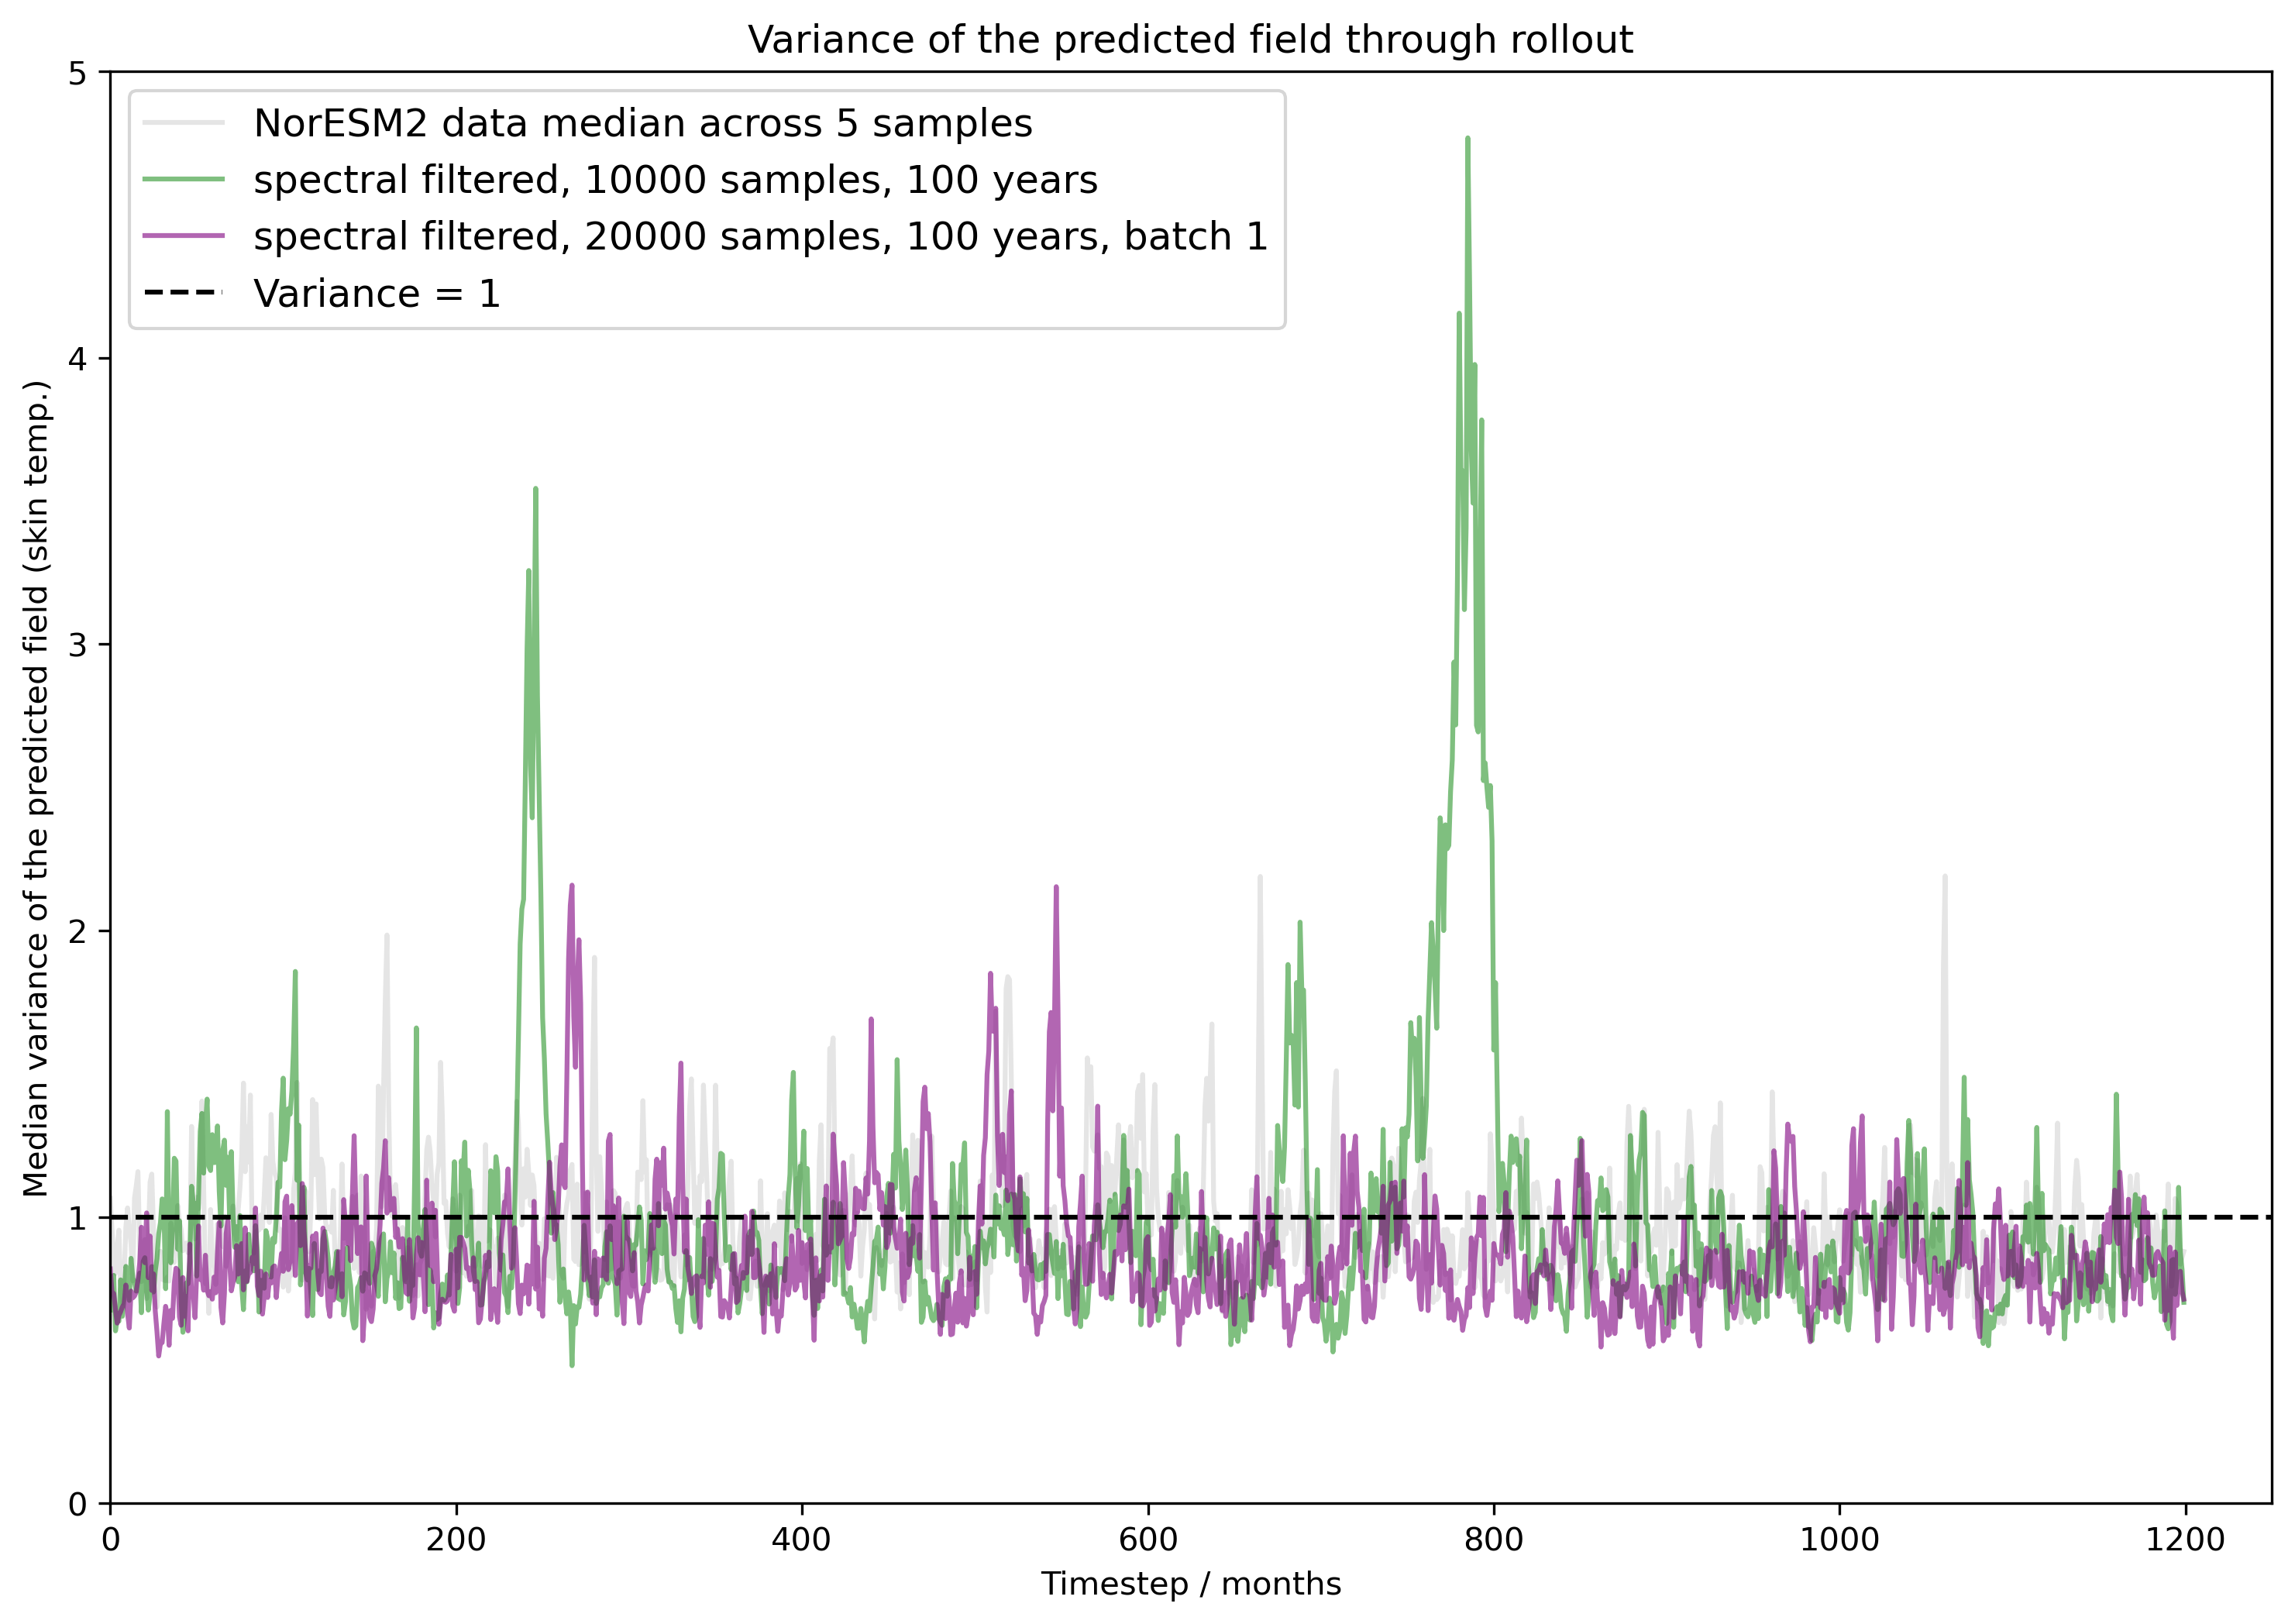

In [67]:
plt.figure(figsize=(12, 8), dpi=300)

# NorESM data
#plt.plot(np.var(cmip_dataset_ts_monthed[:, :, :], axis=(2)), 
#         label='NorESM2 data single trajectory', color='black', alpha=0.5)
plt.plot(np.median(np.var(cmip_dataset_ts_monthed[0:6000, :, :].reshape(1200, 5, 1, -1)[0:1200, :, 0, :], axis=(2)), axis=1), 
         label='NorESM2 data median across 5 samples', color='black', alpha=0.1)
#plt.plot(np.median(np.var(cmip_dataset_ts_monthed[0:6000, :, :].reshape(600, 10, 1, -1)[0:1200, :, 0, :], axis=(2)), axis=1), 
#         label='NorESM2 data median across 10 samples', color='black', alpha=0.3)

# unfiltered
#plt.plot(np.median(np.var(each_timestep_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1), 
#         label='unfiltered', color='skyblue', alpha=0.9)

# filtered for variance
#plt.plot(np.median(np.var(each_timestep_pfvar_20_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1), 
#         label='filtered, 20 samples', color='red', alpha=0.3)
#plt.plot(np.median(np.var(each_timestep_pfvar_100_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1), 
# label='filtered, 100 samples', color='red', alpha=0.6)
#plt.plot(np.median(np.var(each_timestep_pfvar_500_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1), 
#label='filtered, 500 samples', color='red', alpha=0.7)

# filtered for spatial spectra
#plt.plot(np.median(np.var(each_timestep_pfspec_10_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1), 
#         label='spectral filtered, 10 samples', color='skyblue', alpha=0.1)
#plt.plot(np.median(np.var(each_timestep_pfspec_20_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1), 
#         label='spectral filtered, 20 samples', color='skyblue', alpha=0.2)
#plt.plot(np.median(np.var(each_timestep_pfspec_50_samples_50_years_finalvae_picontrol_array[0:60, :, 0, :], axis=(2)), axis=1),
#            label='spectral filtered, 50 samples', color='skyblue', alpha=0.5)
#plt.plot(np.median(np.var(each_timestep_pfspec_100_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1),
#            label='spectral filtered, 100 samples', color='skyblue', alpha=0.5)
#plt.plot(np.median(np.var(each_timestep_pfspec_200_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1),
#            label='spectral filtered, 200 samples', color='skyblue', alpha=0.6)
#plt.plot(np.median(np.var(each_timestep_pfspec_500_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1),
#            label='spectral filtered, 500 samples', color='skyblue', alpha=0.7)
#plt.plot(np.median(np.var(each_timestep_pfspec_1000_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), axis=1),
#            label='spectral filtered, 1000 samples', color='skyblue', alpha=0.8)

# filtered for spatial spectra, mid-latitudes
#plt.plot(np.median(np.var(each_timestep_pfspecmidlats_10_samples_100_years_finalvae_picontrol_array[:, :, 0, :], axis=(2)), axis=1),
#            label='mid-lat spectral filtered, 10 samples, 100 years', color='green', alpha=0.3)
#plt.plot(np.median(np.var(each_timestep_pfspecmidlats_50_samples_100_years_finalvae_picontrol_array[:, :, 0, :], axis=(2)), axis=1),
#            label='mid-lat spectral filtered, 50 samples, 100 years', color='green', alpha=0.6)
#plt.plot(np.median(np.var(each_timestep_pfspecmidlats_100_samples_100_years_finalvae_picontrol_array[:, :, 0, :], axis=(2)), axis=1),
#            label='mid-lat spectral filtered, 100 samples, 100 years', color='green', alpha=0.9)

# filter for spatial spectra, longer rollouts
#plt.plot(np.median(np.var(each_timestep_pfspec_50_samples_50_years_finalvae_picontrol_array[:, :, 0, :], axis=(2)), axis=1),
#            label='spectral filtered, 50 samples, 25 years', color='purple', alpha=0.3)
#plt.plot(np.median(np.var(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array[:, :, 0, :], axis=(2)), axis=1),
#            label='spectral filtered, 300 samples, 16 years', color='purple', alpha=0.6)
#plt.plot(np.median(np.var(each_timestep_pfspec_400_samples_100_years_finalvae_picontrol_array[:, :, 0, :], axis=(2)), axis=1),
#            label='spectral filtered, 400 samples, 25 years', color='purple', alpha=0.8)
#plt.plot(np.median(np.var(each_timestep_pfspec_1000_samples_100_years_finalvae_picontrol_array[:, :, 0, :], axis=(2)), axis=1),
#            label='unclipped spectral filtered, 1000 samples, 25 years', color='purple', alpha=0.6)
#plt.plot(np.median(np.var(each_timestep_pfspecclip_1000_samples_100_years_finalvae_picontrol_array[:, :, 0, :], axis=(2)), axis=1),
#            label='spectral filtered, 1000 samples, 100 years', color='purple', alpha=0.8)
#plt.plot(np.median(np.var(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array[:,  np.random.randint(0, 256, size=10) , 0, :], axis=(2)), axis=1),
#            label='spectral filtered, 2500 samples, 100 years', color='purple', alpha=0.8)

#plt.plot(np.median(np.var(each_timestep_pfspecclip_5000_samples_100_years_64_batch_finalvae_picontrol_array[:,  np.random.randint(0, 64, size=64) , 0, :], axis=(2)), axis=1),
#            label='spectral filtered, 5000 samples, 100 years', color='purple', alpha=0.3)
#plt.plot(np.median(np.var(each_timestep_pfspecclip_10000_samples_100_years_32_batch_finalvae_picontrol_array[:,  : , 0, :], axis=(2)), axis=1),
#            label='spectral filtered, 10000 samples, 100 years', color='maroon', alpha=0.4)
plt.plot(np.median(np.var(each_timestep_pfspecclip_10000_samples_100_years_32_batch_finalvae_picontrol_array[:,  1:2, 0, :], axis=(2)), axis=1),
            label='spectral filtered, 10000 samples, 100 years', color='green', alpha=0.5)
plt.plot(np.median(np.var(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array[:,  1:2 , 0, :], axis=(2)), axis=1),
            label='spectral filtered, 20000 samples, 100 years, batch 1', color='purple', alpha=0.6)
#plt.plot(np.median(np.var(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array[:,  7:8 , 0, :], axis=(2)), axis=1),
#            label='spectral filtered, 20000 samples, 100 years, batch 7', color='purple', alpha=0.6)
#plt.plot(np.median(np.var(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array[:,  9:10 , 0, :], axis=(2)), axis=1),
#            label='spectral filtered, 20000 samples, 100 years, batch 7', color='purple', alpha=0.9)
#plt.plot(np.median(np.var(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array[:,  np.random.randint(0, 16, size=16) , 0, :], axis=(2)), axis=1),
#            label='spectral filtered, 20000 samples, 100 years', color='purple', alpha=0.9)

# filter for spatial spectra with log, high wavenumbers, longer rollouts
#plt.plot(np.median(np.var(each_timestep_pfspeccliplog_1000_samples_100_years_finalvae_picontrol_array[:, :, 0, :], axis=(2)), axis=1),
#            label='spectral filtered, log, 1000 samples, 100 years', color='lightgreen', alpha=0.8)
#plt.plot(np.median(np.var(each_timestep_pfspeccliploghighwav_1000_samples_100_years_finalvae_picontrol_array[:, :, 0, :], axis=(2)), axis=1),
#            label='spectral filtered, log, high wavenumbers, 1000 samples, 100 years', color='lightgreen', alpha=0.8)

plt.axhline(1, color='k', linestyle='--', label='Variance = 1')

# make the y axis a log scale
#plt.yscale('log')

plt.ylim(0, 5)
plt.xlim(0, 1250)

# add axes labels
plt.xlabel('Timestep / months')
plt.ylabel('Median variance of the predicted field (skin temp.)')

plt.legend(fontsize=12)

plt.title('Variance of the predicted field through rollout')

In [83]:
print(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array[:,  1:2, 0, :].shape)
print(np.var(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array[:,  1:2, 0, :], axis=(2)).shape)
print(np.median(np.var(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array[:,  1:2 , 0, :], axis=(2)), axis=0).max())

print(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array[:,  1 , 0, :].shape)
print(np.var(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array[:,  1 , 0, :], axis=(1)).shape)
print(np.median(np.var(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array[:,  1, 0, :], axis=(1)), axis=0).max())

(1200, 1, 6250)
(1200, 1)
0.8104317
(1200, 6250)
(1200,)
0.8104317


In [61]:
print(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array[:,  22 , 0, :])

[[ 7.7943724e-01  6.6732514e-01  1.2058634e+00 ...  9.0898883e-01
   5.4929239e-01 -1.8460752e-01]
 [ 9.2992651e-01  7.2351336e-01  8.0840170e-01 ...  6.9571215e-01
   4.4069082e-01 -2.1187444e-01]
 [ 9.5634058e-02 -4.4769924e-02  4.8747757e-01 ...  3.6033216e-01
  -4.1615358e-01 -9.3979567e-01]
 ...
 [-1.5551556e+00 -1.4952230e+00 -2.3583677e+00 ... -9.7073853e-01
  -1.0933663e+00 -9.2819577e-01]
 [ 2.5297966e+00  2.9936504e+00  3.0262905e-01 ... -6.3297129e-01
  -8.6366051e-01 -1.2302989e+00]
 [ 1.3164344e+00  1.3224919e+00  2.5147900e-01 ...  7.1380422e-02
  -2.6494078e-03  9.6718356e-02]]


In [ ]:
# make a figure with two subplots

fig, axs = plt.subplots(2, 5, figsize=(30, 12), dpi=200)

axs[0, 0].plot(np.var(cmip_dataset_ts_monthed.reshape(36, -1, 1, 6250)[:, :, 0, :], axis=(2)), alpha=0.5)
axs[0, 0].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[0, 0].set_ylim(0, 10)
axs[0, 0].set_xlim(0, 60)
axs[0, 0].set_ylabel('Variance')
axs[0, 0].set_xlabel('Timestep')
axs[0, 0].set_title('Variance of piControl model')

axs[0, 1].plot(np.var(each_timestep_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), alpha=0.5)
axs[0, 1].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[0, 1].set_ylim(0, 10)
axs[0, 1].set_ylabel('Variance')
axs[0, 1].set_xlabel('Timestep')
axs[0, 1].set_title('Unfiltered variance of the rollout, causal graph, piControl')

axs[0, 2].plot(np.var(each_timestep_pfvar_20_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), alpha=0.5)
axs[0, 2].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[0, 2].set_ylim(0, 10)
axs[0, 2].set_ylabel('Variance')
axs[0, 2].set_xlabel('Timestep')
axs[0, 2].set_title('20 sample filtered rollout, causal graph')

axs[0, 3].plot(np.var(each_timestep_pfvar_100_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), alpha=0.5)
axs[0, 3].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[0, 3].set_ylim(0, 10)
axs[0, 3].set_ylabel('Variance')
axs[0, 3].set_xlabel('Timestep')
axs[0, 3].set_title('100 sample filtered rollout, causal graph')

axs[0, 4].plot(np.var(each_timestep_pfvar_500_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), alpha=0.5)
axs[0, 4].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[0, 4].set_ylim(0, 10)
axs[0, 4].set_ylabel('Variance')
axs[0, 4].set_xlabel('Timestep')
axs[0, 4].set_title('500 sample filtered rollout, causal graph')

axs[1, 0].plot(np.var(cmip_dataset_ts_monthed.reshape(36, -1, 1, 6250)[:, [2, 24, 36, 48, 64, 88, 112, 132, 154], 0, :], axis=(2)), alpha=0.5)
axs[1, 0].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[1, 0].set_ylim(0, 10)
axs[1, 0].set_ylabel('Variance')
axs[1, 0].set_xlabel('Timestep')
axs[1, 0].set_title('Samples of piControl variance')

axs[1, 1].plot(np.var(each_timestep_finalvae_picontrol_array[:, 1, 100:108, 0, :], axis=(2)), alpha=0.5)
axs[1, 1].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[1, 1].set_ylim(0, 10)
axs[1, 1].set_ylabel('Variance')
axs[1, 1].set_xlabel('Timestep')
axs[1, 1].set_title('Samples of unfiltered rollout, causal graph')

axs[1, 2].plot(np.var(each_timestep_pfvar_20_samples_finalvae_picontrol_array[:, 1, 100:108, 0, :], axis=(2)), alpha=0.5)
axs[1, 2].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[1, 2].set_ylim(0, 10)
axs[1, 2].set_ylabel('Variance')
axs[1, 2].set_xlabel('Timestep')
axs[1, 2].set_title('Samples of 20 filtered rollout, causal graph')

axs[1, 3].plot(np.var(each_timestep_pfvar_100_samples_finalvae_picontrol_array[:, 1, 100:108, 0, :], axis=(2)), alpha=0.5)
axs[1, 3].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[1, 3].set_ylim(0, 10)
axs[1, 3].set_ylabel('Variance')
axs[1, 3].set_xlabel('Timestep')
axs[1, 3].set_title('Samples of 100 filtered rollout, causal graph')

axs[1, 4].plot(np.var(each_timestep_pfvar_500_samples_finalvae_picontrol_array[:, 1, 100:108, 0, :], axis=(2)), alpha=0.5)
axs[1, 4].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[1, 4].set_ylim(0, 10)
axs[1, 4].set_ylabel('Variance')
axs[1, 4].set_xlabel('Timestep')
axs[1, 4].set_title('Samples of 500 filtered rollout, causal graph')

In [ ]:
# make a figure with two subplots

fig, axs = plt.subplots(2, 5, figsize=(30, 12), dpi=200)

axs[0, 0].plot(np.var(cmip_dataset_ts_monthed.reshape(36, -1, 1, 6250)[:, :, 0, :], axis=(2)), alpha=0.5)
axs[0, 0].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[0, 0].set_ylim(0, 10)
axs[0, 0].set_xlim(0, 60)
axs[0, 0].set_ylabel('Variance')
axs[0, 0].set_xlabel('Timestep')
axs[0, 0].set_title('Variance of piControl model')

axs[0, 1].plot(np.var(each_timestep_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), alpha=0.5)
axs[0, 1].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[0, 1].set_ylim(0, 10)
axs[0, 1].set_ylabel('Variance')
axs[0, 1].set_xlabel('Timestep')
axs[0, 1].set_title('Unfiltered variance of the rollout, causal graph, piControl')

axs[0, 2].plot(np.var(each_timestep_pfspec_100_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), alpha=0.5)
axs[0, 2].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[0, 2].set_ylim(0, 10)
axs[0, 2].set_ylabel('Variance')
axs[0, 2].set_xlabel('Timestep')
axs[0, 2].set_title('100 sample spectral filtered rollout, causal graph')

axs[0, 3].plot(np.var(each_timestep_pfspec_500_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), alpha=0.5)
axs[0, 3].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[0, 3].set_ylim(0, 10)
axs[0, 3].set_ylabel('Variance')
axs[0, 3].set_xlabel('Timestep')
axs[0, 3].set_title('500 sample spectral filtered rollout, causal graph')

axs[0, 4].plot(np.var(each_timestep_pfspec_1000_samples_finalvae_picontrol_array[:, 1, :, 0, :], axis=(2)), alpha=0.5)
axs[0, 4].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[0, 4].set_ylim(0, 10)
axs[0, 4].set_ylabel('Variance')
axs[0, 4].set_xlabel('Timestep')
axs[0, 4].set_title('1000 sample spectral filtered rollout, causal graph')

axs[1, 0].plot(np.var(cmip_dataset_ts_monthed.reshape(36, -1, 1, 6250)[:, [2, 24, 36, 48, 64, 88, 112, 132, 154], 0, :], axis=(2)), alpha=0.5)
axs[1, 0].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[1, 0].set_ylim(0, 10)
axs[1, 0].set_ylabel('Variance')
axs[1, 0].set_xlabel('Timestep')
axs[1, 0].set_title('Samples of piControl variance')

axs[1, 1].plot(np.var(each_timestep_finalvae_picontrol_array[:, 1, 100:108, 0, :], axis=(2)), alpha=0.5)
axs[1, 1].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[1, 1].set_ylim(0, 10)
axs[1, 1].set_ylabel('Variance')
axs[1, 1].set_xlabel('Timestep')
axs[1, 1].set_title('Samples of unfiltered rollout, causal graph')

axs[1, 2].plot(np.var(each_timestep_pfspec_20_samples_finalvae_picontrol_array[:, 1, 100:108, 0, :], axis=(2)), alpha=0.5)
axs[1, 2].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[1, 2].set_ylim(0, 10)
axs[1, 2].set_ylabel('Variance')
axs[1, 2].set_xlabel('Timestep')
axs[1, 2].set_title('Samples of 20 filtered rollout, causal graph')

axs[1, 3].plot(np.var(each_timestep_pfspec_100_samples_finalvae_picontrol_array[:, 1, 100:108, 0, :], axis=(2)), alpha=0.5)
axs[1, 3].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[1, 3].set_ylim(0, 10)
axs[1, 3].set_ylabel('Variance')
axs[1, 3].set_xlabel('Timestep')
axs[1, 3].set_title('Samples of 100 filtered rollout, causal graph')

axs[1, 4].plot(np.var(each_timestep_pfspec_500_samples_finalvae_picontrol_array[:, 1, 100:108, 0, :], axis=(2)), alpha=0.5)
axs[1, 4].axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
axs[1, 4].set_ylim(0, 10)
axs[1, 4].set_ylabel('Variance')
axs[1, 4].set_xlabel('Timestep')
axs[1, 4].set_title('Samples of 500 filtered rollout, causal graph')

Plot a video of the results here:

In [55]:
def plot_preds_icosa_robin_video_array_cmip(each_timestep, sample, coordinates:np.ndarray, out_dir:str, fname:str, show_plot:bool = True):
    '''
    Plotting global maps of the predictions using the Robinson projection.
    We use the plot_preds_icosa_robin function.
    '''
    img_array = []
    for timestep in range(len(each_timestep)):
        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(12, 6))
        plot_preds_icosa_robin_cmip(each_timestep[timestep, 0, :], coordinates, ax, timestep, "plots", show_plot=show_plot)
        filename = f"{out_dir}/just_icosa_pred_timestep_{timestep}.png"
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)
        # add a title to the plot
        ax.set_title(f'NorESM2 model data, timestep {timestep}')
        # add a colorbar
        
    print('Done plotting all samples.')

    out = cv2.VideoWriter(f'{out_dir}/{fname}.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 3, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

def plot_preds_icosa_robin_cmip(data, coordinates, axs, timestep, out_dir, show_plot=True):

    axs.set_global()
    axs.coastlines()
    # Add some map features for context
    axs.add_feature(cfeature.BORDERS, linestyle=':')
    axs.add_feature(cfeature.COASTLINE)
    axs.add_feature(cfeature.LAND, edgecolor='black')
    axs.gridlines(draw_labels=False)

    # Unpack coordinates for vectorized scatter plot
    x = coordinates[:, 0]
    y = coordinates[:, 1]

    # Vectorized scatter plot with color array
    s = axs.scatter(x=x, y=y, c=data, alpha=1, s=30, vmin=-3.5, vmax=3.5, cmap="RdBu_r", transform=ccrs.PlateCarree())  # Store scatter plot object

    # add a colorbar
    plt.colorbar(s, ax=axs, label="Normalised anomaly", orientation="vertical", shrink=1.0) # adjust shrink
    #axs.colorbar(s, ax=axs, label="Normalised slp", orientation="vertical", shrink=1.0) # adjust shrink

    # add a title
    plt.title(f"Timestep {timestep} of NorESM model data")
    
    fname = f"{out_dir}/just_icosa_pred_timestep_{timestep}.png"
    #plt.suptitle(f"Plot of timestep {timestep}")    
    plt.savefig(fname)

    if show_plot == False:
        plt.close()


def plot_preds_icosa_robin_video_array(each_timestep, sample, coordinates:np.ndarray, out_dir:str, fname:str, show_plot:bool = True):
    '''
    Plotting global maps of the predictions using the Robinson projection.
    We use the plot_preds_icosa_robin function.
    '''
    img_array = []
    for timestep in range(len(each_timestep)):
        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(12, 6))
        plot_preds_icosa_robin(each_timestep[timestep, sample, 0, :], coordinates, ax, timestep, "plots", show_plot=show_plot)
        filename = f"{out_dir}/just_icosa_pred_timestep_{timestep}.png"
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)
        # add a title to the plot
        ax.set_title(f'Autoregressive rollout, timestep {timestep}')
        # add a colorbar
        
    print('Done plotting all samples.')

    out = cv2.VideoWriter(f'{out_dir}/{fname}.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 3, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()


In [56]:
cmip_dataset_ts_monthed.shape

(6012, 1, 6250)

In [66]:
plot_preds_icosa_robin_video_array_cmip(cmip_dataset_ts_monthed[5:1205, :, :], 0, coordinates, "plots", "noresm2_picontrol_100_years_start_1_ar_indexing", show_plot=False)

Done plotting all samples.


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [ ]:
plot_preds_icosa_robin_video_array(each_timestep_finalvae_picontrol_array[:, 1, :, :, :], 92, coordinates, "plots", "finalvae_picontrol_92", show_plot=False)

plot_preds_icosa_robin_video_array(each_timestep_pfvar_20_samples_finalvae_picontrol_array[:, 1, :, :, :], 92, coordinates, "plots", "finalvae_filtered_20_picontrol_92", show_plot=False)

plot_preds_icosa_robin_video_array(each_timestep_pfvar_100_samples_finalvae_picontrol_array[:, 1, :, :, :], 92, coordinates, "plots", "finalvae_filtered_100_picontrol_92", show_plot=False)

#plot_preds_icosa_robin_video_array(each_timestep_pfvar_500_samples_finalvae_picontrol_array[:, 1, :, :, :], 92, coordinates, "plots", "finalvae_filtered_500_picontrol_92", show_plot=False)



In [ ]:
plot_preds_icosa_robin_video_array(each_timestep_pfspec_20_samples_finalvae_picontrol_array[:, 1, :, :, :], 92, coordinates, "plots", "finalvae_filtered_spectra_20_picontrol_92", show_plot=False)

plot_preds_icosa_robin_video_array(each_timestep_pfspec_100_samples_finalvae_picontrol_array[:, 1, :, :, :], 92, coordinates, "plots", "finalvae_filtered_spectra_100_picontrol_92", show_plot=False)

plot_preds_icosa_robin_video_array(each_timestep_pfspec_500_samples_finalvae_picontrol_array[:, 1, :, :, :], 92, coordinates, "plots", "finalvae_filtered_spectra_500_picontrol_92", show_plot=False)

plot_preds_icosa_robin_video_array(each_timestep_pfspec_1000_samples_finalvae_picontrol_array[:, 1, :, :, :], 92, coordinates, "plots", "finalvae_filtered_spectra_1000_picontrol_92", show_plot=False)


In [ ]:
# really long
# note this has 1 fewer dimension
plot_preds_icosa_robin_video_array(each_timestep_pfspec_400_samples_100_years_finalvae_picontrol_array[:, :, :, :], 92, coordinates, "plots", "finalvae_filtered_spectra_400_25_years_picontrol_92", show_plot=False)

plot_preds_icosa_robin_video_array(each_timestep_pfspec_1000_samples_100_years_finalvae_picontrol_array[:, :, :, :], 92, coordinates, "plots", "finalvae_filtered_spectra_1000_25_years_picontrol_92", show_plot=False)


In [ ]:
plot_preds_icosa_robin_video_array(each_timestep_pfspec_1000_samples_100_years_finalvae_picontrol_array[:, :, :, :], 108, coordinates, "plots", "finalvae_filtered_spectra_1000_25_years_picontrol_108", show_plot=False)


In [ ]:
plot_preds_icosa_robin_video_array(each_timestep_pfspecclip_1000_samples_100_years_finalvae_picontrol_array[:, :, :, :], 108, coordinates, "plots", "finalvae_filtered_spectra_1000_100_years_picontrol_108", show_plot=False)


In [68]:
plot_preds_icosa_robin_video_array(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array[:, :, :, :], 1, coordinates, "plots", "finalvae_filtered_spectra_20000_100_years_16_batch_picontrol_1", show_plot=False)


Done plotting all samples.


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [67]:
plot_preds_icosa_robin_video_array(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array[:, :, :, :], 22, coordinates, "plots", "finalvae_filtered_spectra_2500_100_years_picontrol_22", show_plot=False)


Done plotting all samples.


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


# Evaluate the skill of the rollout here:

In [63]:
# Match up the forecast with the actual data

# here we have function to match up data from the autoregressive model to the CMIP data

def match_ar_indices_to_cmip_data(each_timestep_array: np.ndarray, cmip_dataset: np.ndarray, coordinates: np.ndarray) -> tuple[int, int]:
    """
    This function takes the autoregressive predictions and the CMIP dataset and finds the indices of the CMIP dataset
    that correspond to the autoregressive predictions. It returns a list of tuples, where the first element of the tuple
    is the index of the autoregressive prediction, and the second element is the index of the CMIP dataset.
    """
    list_of_indexes = []

    for x in range(0, each_timestep_array.shape[2]):
        for i in range(0, cmip_dataset.shape[0]):
            if np.sum(np.abs(each_timestep_array[0, 0, x, 0, :] - cmip_dataset[i, 0, :])) <= 10.0:
                list_of_indexes.append((x, i))
                print(f"Matched AR index {x} to CMIP index {i}")
    return list_of_indexes


In [64]:
cmip_dataset_ts_monthed.shape

(6012, 1, 6250)

In [65]:
list_of_indices = match_ar_indices_to_cmip_data(each_timestep_pfvar_20_samples_finalvae_picontrol_array, cmip_dataset_ts_monthed, coordinates)

# list_of_indices2 = match_ar_indices_to_cmip_data(each_timestep_finalvae_picontrol_array, cmip_dataset_ts_monthed, coordinates)
# assert list_of_indices == list_of_indices2


Matched AR index 0 to CMIP index 4
Matched AR index 1 to CMIP index 5
Matched AR index 2 to CMIP index 6
Matched AR index 3 to CMIP index 7
Matched AR index 4 to CMIP index 8
Matched AR index 5 to CMIP index 9
Matched AR index 6 to CMIP index 10
Matched AR index 7 to CMIP index 11
Matched AR index 8 to CMIP index 12
Matched AR index 9 to CMIP index 13
Matched AR index 10 to CMIP index 14
Matched AR index 11 to CMIP index 15
Matched AR index 12 to CMIP index 16
Matched AR index 13 to CMIP index 17
Matched AR index 14 to CMIP index 18
Matched AR index 15 to CMIP index 19
Matched AR index 16 to CMIP index 20
Matched AR index 17 to CMIP index 21
Matched AR index 18 to CMIP index 22
Matched AR index 19 to CMIP index 23
Matched AR index 20 to CMIP index 24
Matched AR index 21 to CMIP index 25
Matched AR index 22 to CMIP index 26
Matched AR index 23 to CMIP index 27
Matched AR index 24 to CMIP index 28
Matched AR index 25 to CMIP index 29
Matched AR index 26 to CMIP index 30
Matched AR index 

In [86]:
array_of_indices = np.array(list_of_indices)
array_of_indices.shape

# select just the second column of this array

cmip_indices = array_of_indices[:, 1]

In [107]:
# make this into a function

def calculate_mse_mae_for_each_sample(each_timestep_array: np.ndarray, cmip_dataset: np.ndarray, cmip_indices: np.ndarray, timesteps:int = 60) -> tuple[list, list]:

    all_mses = []
    all_maes = []

    for sample in range(0, each_timestep_array.shape[2]):

        mse_per_sample = []
        mae_per_sample = []
        starting_point_per_sample = cmip_indices[sample]

        for timestep in range(0, timesteps):

            mse_per_sample.append(mean_squared_error(cmip_dataset[starting_point_per_sample+timestep, 0, :], each_timestep_array[timestep, 1, sample, 0, :])) 
            mae_per_sample.append(mean_absolute_error(cmip_dataset[starting_point_per_sample+timestep, 0, :], each_timestep_array[timestep, 1, sample, 0, :])) 

        all_mses.append(mse_per_sample)
        all_maes.append(mae_per_sample)

    return np.array(all_mses), np.array(all_maes)

def calculate_mse_mae_for_each_sample_just_preds(each_timestep_array: np.ndarray, cmip_dataset: np.ndarray, cmip_indices: np.ndarray, timesteps:int = 60) -> tuple[list, list]:

    all_mses = []
    all_maes = []

    for sample in range(0, each_timestep_array.shape[2]):

        mse_per_sample = []
        mae_per_sample = []
        starting_point_per_sample = cmip_indices[sample]

        for timestep in range(0, timesteps):

            mse_per_sample.append(mean_squared_error(cmip_dataset[starting_point_per_sample+timestep, 0, :], each_timestep_array[timestep, sample, 0, :])) 
            mae_per_sample.append(mean_absolute_error(cmip_dataset[starting_point_per_sample+timestep, 0, :], each_timestep_array[timestep, sample, 0, :])) 

        all_mses.append(mse_per_sample)
        all_maes.append(mae_per_sample)

    return np.array(all_mses), np.array(all_maes)

In [469]:
# variance:

all_mses_finalvae_picontrol_array, all_maes_finalvae_picontrol_array = calculate_mse_mae_for_each_sample(each_timestep_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=48)
all_mses_pfvar_20_samples_finalvae_picontrol_array, all_maes_pfvar_20_samples_finalvae_picontrol_array = calculate_mse_mae_for_each_sample(each_timestep_pfvar_20_samples_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=48)
all_mses_pfvar_100_samples_finalvae_picontrol_array, all_maes_pfvar_100_samples_finalvae_picontrol_array = calculate_mse_mae_for_each_sample(each_timestep_pfvar_100_samples_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=60)
all_mses_pfvar_500_samples_finalvae_picontrol_array, all_maes_pfvar_500_samples_finalvae_picontrol_array = calculate_mse_mae_for_each_sample(each_timestep_pfvar_500_samples_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=60)

In [470]:
# spectral: 

all_mses_pfspec_10_samples_finalvae_picontrol_array, all_maes_pfspec_10_samples_finalvae_picontrol_array = calculate_mse_mae_for_each_sample(each_timestep_pfspec_10_samples_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=60)
all_mses_pfspec_20_samples_finalvae_picontrol_array, all_maes_pfspec_20_samples_finalvae_picontrol_array = calculate_mse_mae_for_each_sample(each_timestep_pfspec_20_samples_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=60)
all_mses_pfspec_100_samples_finalvae_picontrol_array, all_maes_pfspec_100_samples_finalvae_picontrol_array = calculate_mse_mae_for_each_sample(each_timestep_pfspec_100_samples_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=60)
all_mses_pfspec_200_samples_finalvae_picontrol_array, all_maes_pfspec_200_samples_finalvae_picontrol_array = calculate_mse_mae_for_each_sample(each_timestep_pfspec_200_samples_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=60)
all_mses_pfspec_500_samples_finalvae_picontrol_array, all_maes_pfspec_500_samples_finalvae_picontrol_array = calculate_mse_mae_for_each_sample(each_timestep_pfspec_500_samples_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=60)
all_mses_pfspec_1000_samples_finalvae_picontrol_array, all_maes_pfspec_1000_samples_finalvae_picontrol_array = calculate_mse_mae_for_each_sample(each_timestep_pfspec_1000_samples_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=60)

In [471]:
# spectral, longer rollouts

all_mses_pfspec_20_samples_20_years_finalvae_picontrol_array, all_maes_pfspec_20_samples_20_years_finalvae_picontrol_array = calculate_mse_mae_for_each_sample_just_preds(each_timestep_pfspec_20_samples_20_years_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=240)
all_mses_pfspec_50_samples_50_years_finalvae_picontrol_array, all_maes_pfspec_50_samples_50_years_finalvae_picontrol_array = calculate_mse_mae_for_each_sample_just_preds(each_timestep_pfspec_50_samples_50_years_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=300)
all_mses_pfspec_300_samples_50_years_finalvae_picontrol_array, all_maes_pfspec_300_samples_50_years_finalvae_picontrol_array = calculate_mse_mae_for_each_sample_just_preds(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=200)

In [108]:
# really long rollouts
all_mses_pfspecclip_2500_samples_100_years_finalvae_picontrol_array, all_maes_pfspecclip_2500_samples_100_years_finalvae_picontrol_array = calculate_mse_mae_for_each_sample_just_preds(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=1200)
                                                                                                                                                                         

NameError: name 'cmip_indices' is not defined

In [472]:
# mid-latitude spectral

all_mses_pfspec_50_samples_10_years_finalvae_picontrol_array, all_maes_pfspec_50_samples_10_years_finalvae_picontrol_array = calculate_mse_mae_for_each_sample_just_preds(each_timestep_pfspec_50_samples_100_years_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=120)
all_mses_pfspec_100_samples_10_years_finalvae_picontrol_array, all_maes_pfspec_100_samples_10_years_finalvae_picontrol_array = calculate_mse_mae_for_each_sample_just_preds(each_timestep_pfspec_100_samples_100_years_finalvae_picontrol_array, cmip_dataset_ts_monthed, cmip_indices, timesteps=120)


In [104]:
# now I can loop through each of these starting points and calculate the mean squared error for each of the samples

all_mses_t0_persistence = []
all_maes_t0_persistence = []

for sample in range(0, each_timestep_finalvae_picontrol_array.shape[2]):

    mse_per_sample = []
    mae_per_sample = []
    starting_point_per_sample = cmip_indices[sample]

    for timestep in range(0, 600):
        mse_per_sample.append(mean_squared_error(cmip_dataset_ts_monthed[starting_point_per_sample+timestep, 0, :], cmip_dataset_ts_monthed[starting_point_per_sample-1, 0, :])) 
        mae_per_sample.append(mean_absolute_error(cmip_dataset_ts_monthed[starting_point_per_sample+timestep, 0, :], cmip_dataset_ts_monthed[starting_point_per_sample-1, 0, :])) 

    all_mses_t0_persistence.append(mse_per_sample)
    all_maes_t0_persistence.append(mae_per_sample)

all_mses_t0_persistence_array = np.array(all_mses_t0_persistence)
all_maes_t0_persistence_array = np.array(all_maes_t0_persistence)

In [92]:
# Assuming all_mses_array is defined elsewhere in your notebook

def calulate_mean_median_stds(all_maes_array: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:

    mean_maes = np.mean(all_maes_array, axis=0)
    median_maes = np.median(all_maes_array, axis=0)
    stds_maes = np.std(all_maes_array, axis=0)

    return mean_maes, median_maes, stds_maes

In [478]:



mean_finalvae_maes, median_finalvae_maes, mean_finalvae_stds = calulate_mean_median_stds(all_maes_finalvae_picontrol_array)

# variance filtered
mean_pfvar_20_samples_finalvae_maes, median_pfvar_20_samples_finalvae_maes, mean_pfvar_20_samples_finalvae_stds = calulate_mean_median_stds(all_maes_pfvar_20_samples_finalvae_picontrol_array)
mean_pfvar_100_samples_finalvae_maes, median_pfvar_100_samples_finalvae_maes, mean_pfvar_100_samples_finalvae_stds = calulate_mean_median_stds(all_maes_pfvar_100_samples_finalvae_picontrol_array)
mean_pfvar_500_samples_finalvae_maes, median_pfvar_500_samples_finalvae_maes, mean_pfvar_500_samples_finalvae_stds = calulate_mean_median_stds(all_maes_pfvar_500_samples_finalvae_picontrol_array)

# spectral filtered
mean_pfspec_10_samples_finalvae_maes, median_pfspec_10_samples_finalvae_maes, mean_pfspec_10_samples_finalvae_stds = calulate_mean_median_stds(all_maes_pfspec_10_samples_finalvae_picontrol_array)
mean_pfspec_20_samples_finalvae_maes, median_pfspec_20_samples_finalvae_maes, mean_pfspec_20_samples_finalvae_stds = calulate_mean_median_stds(all_maes_pfspec_20_samples_finalvae_picontrol_array)
mean_pfspec_100_samples_finalvae_maes, median_pfspec_100_samples_finalvae_maes, mean_pfspec_100_samples_finalvae_stds = calulate_mean_median_stds(all_maes_pfspec_100_samples_finalvae_picontrol_array)
mean_pfspec_200_samples_finalvae_maes, median_pfspec_200_samples_finalvae_maes, mean_pfspec_200_samples_finalvae_stds = calulate_mean_median_stds(all_maes_pfspec_200_samples_finalvae_picontrol_array)
mean_pfspec_500_samples_finalvae_maes, median_pfspec_500_samples_finalvae_maes, mean_pfspec_500_samples_finalvae_stds = calulate_mean_median_stds(all_maes_pfspec_500_samples_finalvae_picontrol_array)
mean_pfspec_1000_samples_finalvae_maes, median_pfspec_1000_samples_finalvae_maes, mean_pfspec_1000_samples_finalvae_stds = calulate_mean_median_stds(all_maes_pfspec_1000_samples_finalvae_picontrol_array)

# spectral filtered, longer rollouts
mean_pfspec_20_samples_20_years_finalvae_maes, median_pfspec_20_samples_20_years_finalvae_maes, mean_pfspec_20_samples_20_years_finalvae_stds = calulate_mean_median_stds(all_maes_pfspec_20_samples_20_years_finalvae_picontrol_array)
mean_pfspec_50_samples_50_years_finalvae_maes, median_pfspec_50_samples_50_years_finalvae_maes, mean_pfspec_50_samples_50_years_finalvae_stds = calulate_mean_median_stds(all_maes_pfspec_50_samples_50_years_finalvae_picontrol_array)
mean_pfspec_300_samples_50_years_finalvae_maes, median_pfspec_300_samples_50_years_finalvae_maes, mean_pfspec_300_samples_50_years_finalvae_stds = calulate_mean_median_stds(all_maes_pfspec_300_samples_50_years_finalvae_picontrol_array)

# mid-latitude spectral
mean_pfspec_50_samples_10_years_finalvae_maes, median_pfspec_50_samples_10_years_finalvae_maes, mean_pfspec_50_samples_10_years_finalvae_stds = calulate_mean_median_stds(all_maes_pfspec_50_samples_10_years_finalvae_picontrol_array)
mean_pfspec_100_samples_10_years_finalvae_maes, median_pfspec_100_samples_10_years_finalvae_maes, mean_pfspec_100_samples_10_years_finalvae_stds = calulate_mean_median_stds(all_maes_pfspec_100_samples_10_years_finalvae_picontrol_array)







In [106]:
# persistence
mean_persistence_maes, median_persistence_maes, mean_persistence_stds = calulate_mean_median_stds(all_maes_t0_persistence_array)

In [98]:
mean_pfspecclip_2500_samples_100_years_finalvae_maes, median_pfspecclip_2500_samples_100_years_finalvae_maes, mean_pfspecclip_2500_samples_100_years_finalvae_stds = calulate_mean_median_stds(all_maes_pfspecclip_2500_samples_100_years_finalvae_picontrol_array)


In [106]:
plt.figure(figsize=(12, 6))

# Plot the mean
#plt.plot(mean_finalvae_maes, label='Causal, unfiltered, piControl', color='purple', alpha=0.5)
#plt.plot(mean_pfvar_20_samples_finalvae_maes, label='Causal, 20 samples, piControl', color='purple', alpha=0.6, linestyle="--")
#plt.plot(mean_pfvar_100_samples_finalvae_maes, label='Causal, 100 samples, piControl', color='purple', alpha=0.7, linestyle="-.")
#plt.plot(mean_pfvar_500_samples_finalvae_maes, label='Causal, 500 samples, piControl', color='purple', alpha=0.8, linestyle="-.")

#plt.plot(median_finalvae_maes, label='Causal, unfiltered, piControl', color='skyblue', alpha=0.3)
#plt.plot(median_pfvar_20_samples_finalvae_maes, label='Causal, 20 samples, piControl', color='skyblue', alpha=0.4, linestyle="--")
#plt.plot(median_pfvar_100_samples_finalvae_maes, label='Causal, 100 samples, piControl', color='skyblue', alpha=0.5, linestyle="-.")
#plt.plot(median_pfvar_500_samples_finalvae_maes, label='Causal, 500 samples, piControl', color='skyblue', alpha=0.7, linestyle="-.")

#plt.plot(median_pfspec_10_samples_finalvae_maes, label='Spectral, 10 samples, piControl', color='orange', alpha=0.3)
#plt.plot(median_pfspec_20_samples_finalvae_maes, label='Spectral, 20 samples, piControl', color='orange', alpha=0.4, linestyle="--")
#plt.plot(median_pfspec_100_samples_finalvae_maes, label='Spectral, 100 samples, piControl', color='orange', alpha=0.6, linestyle="-.")
#plt.plot(median_pfspec_200_samples_finalvae_maes, label='Spectral, 200 samples, piControl', color='orange', alpha=0.8, linestyle="-.")
#plt.plot(median_pfspec_500_samples_finalvae_maes, label='Spectral, 500 samples, piControl', color='orange', alpha=1.0, linestyle=":")
#plt.plot(median_pfspec_1000_samples_finalvae_maes, label='Spectral, 1000 samples, piControl', color='orange', alpha=1.0, linestyle="-")

#plt.plot(median_pfspec_20_samples_20_years_finalvae_maes, label='Spectral, 20 samples, 20 years, piControl', color='red', alpha=0.4, linestyle="--")
#plt.plot(median_pfspec_50_samples_50_years_finalvae_maes, label='Spectral, 50 samples, 50 years, piControl', color='red', alpha=0.6, linestyle="-.")
#plt.plot(median_pfspec_300_samples_50_years_finalvae_maes, label='Spectral, 300 samples, 50 years, piControl', color='red', alpha=0.8, linestyle=":")

plt.plot(median_pfspecclip_2500_samples_100_years_finalvae_maes, label='Spectral, 2500 samples, 100 years, piControl', color='green', alpha=0.4, linestyle="--")

#plt.plot(mean_vae_ssp245_mses, label='VAE SSP245')
plt.plot(mean_persistence_maes, label='Persistence', alpha=0.3, color='k', linestyle='--')


#plt.axhline(y=1.0, color='r', linestyle='--')
#plt.axvline(x=2, color='r', linestyle='--')

plt.ylabel('Mean Absolute Error')
plt.xlabel('Timestep / months')

# Plot the standard deviation bounds
#plt.fill_between(range(len(mean_mses)), lower_bound, upper_bound, color='gray', alpha=0.1, label='Standard Deviation')

plt.ylim(0,5)
#plt.xlim(-1,300)

# make y axis a log scale
#plt.yscale('log')

plt.legend(fontsize=8)
plt.show()

NameError: name 'median_pfspecclip_2500_samples_100_years_finalvae_maes' is not defined

<Figure size 1200x600 with 0 Axes>

# Assess ENSO and further on do the seasonal cycle:

Start with ENSO because I am an absolute psychopath.

In [86]:
# Do the same thing for the Nino 3.4 index.
# 5N-5S;170W-120W
# to do this I need to go through the coordinates and find the ones that are closest to the Nino 3.4 index

nino34 = []
for i in range(0, coordinates.shape[0]):
    if coordinates[i, 0] >= -170 and coordinates[i, 0] <= -120 and coordinates[i, 1] >= -5 and coordinates[i, 1] <= 5:
        nino34.append(i)

Plot to make sure this is correct.

In [90]:
# select just the data from each_timestep_train_array and each_timestep_val_array that corresponds to the Nino 3.4 index

#each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_nino34 = each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array[:, :, :, nino34]

# THIS ONE WAS USED TO MAKE PLOTS IN THE CURRENT PAPER
#each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_nino34 = each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array[:, :, :, nino34]


each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_nino34 = each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array[:, :, :, nino34]
# do the same for the actual data from the CMIP dataset

cmip_dataset_ts_monthed_nino34 = cmip_dataset_ts_monthed[:, :, nino34]

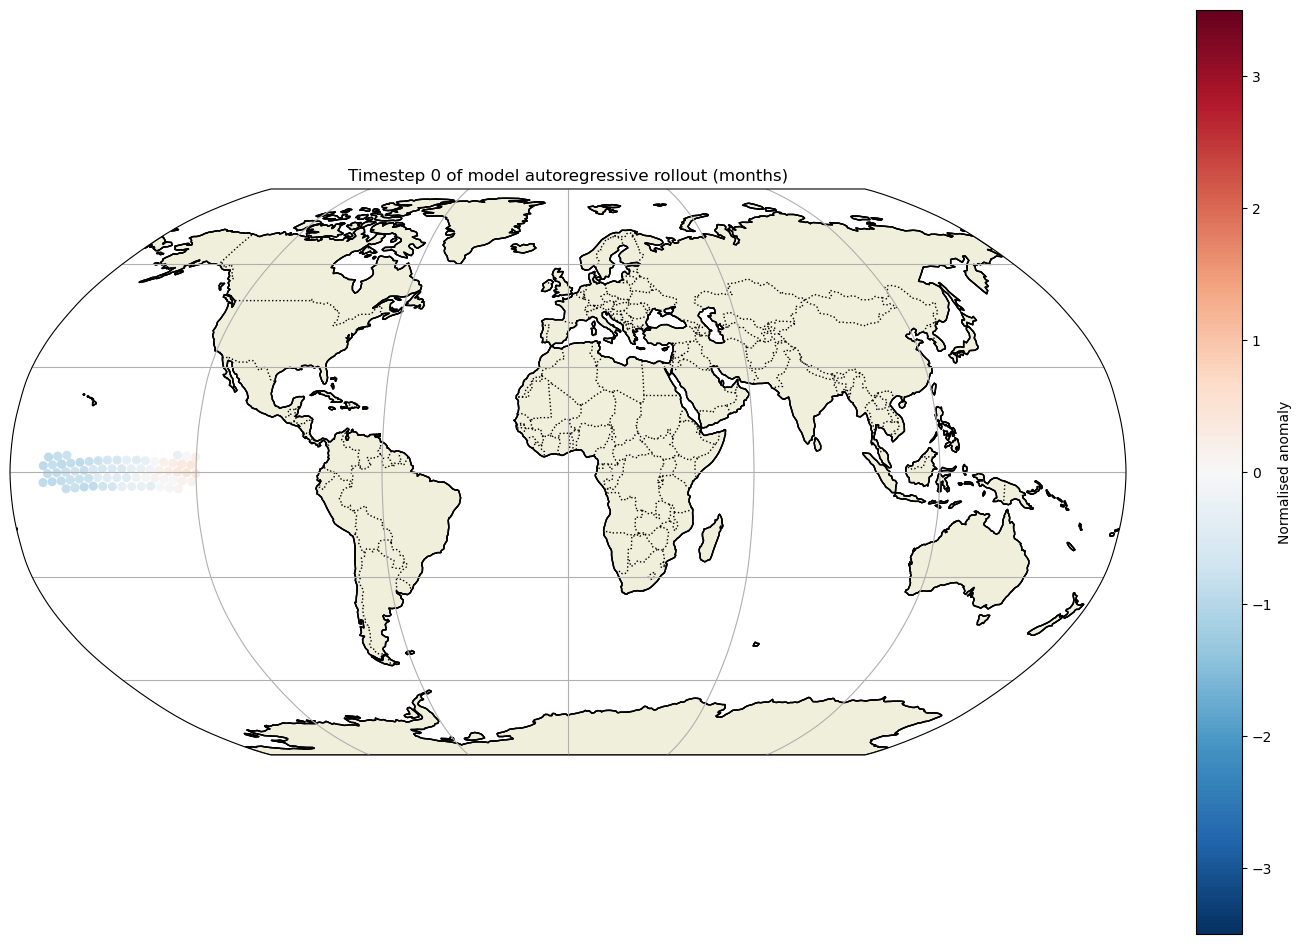

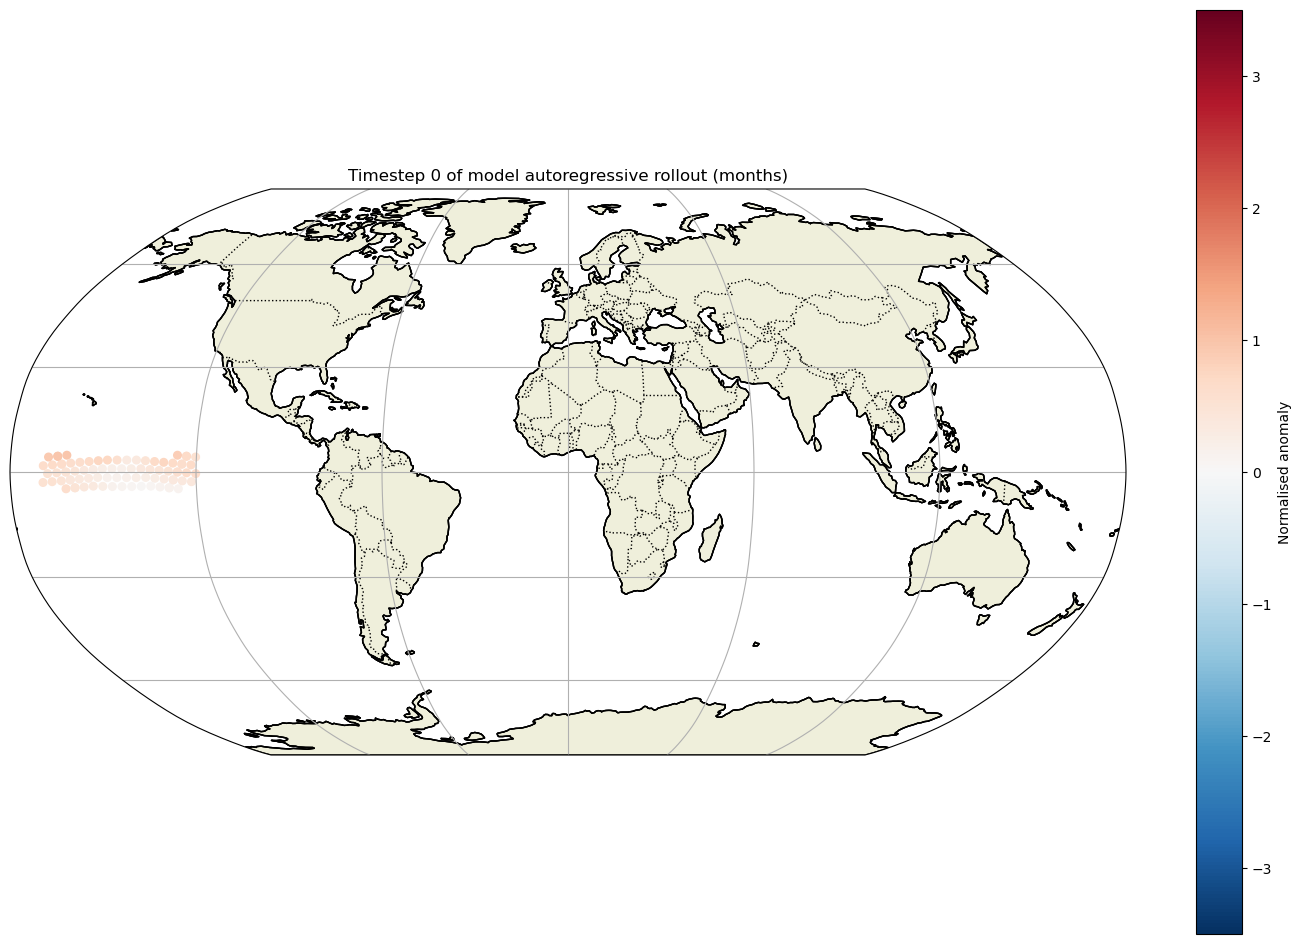

In [91]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(18, 12))
plot_preds_icosa_robin(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_nino34[0, 0, 0, :], coordinates[nino34, :], ax, 0, '.', True)

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(18, 12))
plot_preds_icosa_robin(cmip_dataset_ts_monthed_nino34[26, :, :], coordinates[nino34, :], ax, 0, '.', True)

# I need to take the mean here!

We actually want the three month mean!

In [92]:
print(cmip_dataset_ts_monthed_nino34.shape)

# take the mean of this:

cmip_dataset_ts_monthed_nino34_mean = cmip_dataset_ts_monthed_nino34.mean(axis=2)
#cmip_dataset_ts_monthed_nino34_mean = cmip_dataset_ts_monthed_nino34_mean.reshape(9612, 1, 1)
print(cmip_dataset_ts_monthed_nino34_mean.shape)

(6012, 1, 80)
(6012, 1)


I have to think carefully here about what I should use for indexing, here I just take a random sample.

In [94]:
# SELECTING SAMPLE = 23

#sample = 23

#print(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_nino34.shape)
#each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_nino34_mean = each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_nino34.mean(axis=3)

print(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_nino34.shape)
each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_nino34_mean = each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_nino34.mean(axis=3)

#each_timestep_train_array_nino34_mean = each_timestep_train_array_nino34_mean.reshape(60, 3, 512, 1, 1)

#print(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_nino34_mean.shape)
print(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_nino34_mean.shape)

(1200, 16, 1, 80)
(1200, 16, 1)


(-50.0, 50.0)

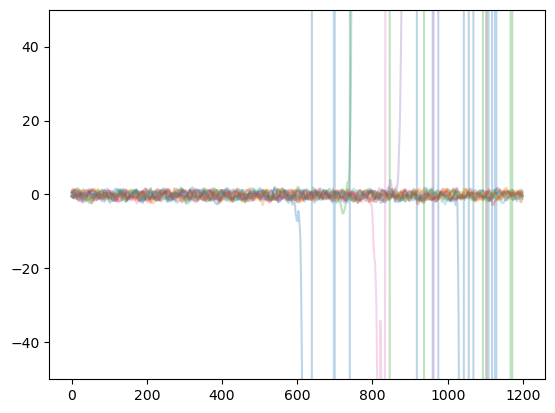

In [97]:
plt.plot(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_nino34_mean[0:1200, :, 0], label='Model Nino3.4 index', alpha=0.3)

plt.ylim(-50,50)
#plt.yscale('log')

Text(0.5, 1.0, 'Nino3.4 index across 100 years of climate model')

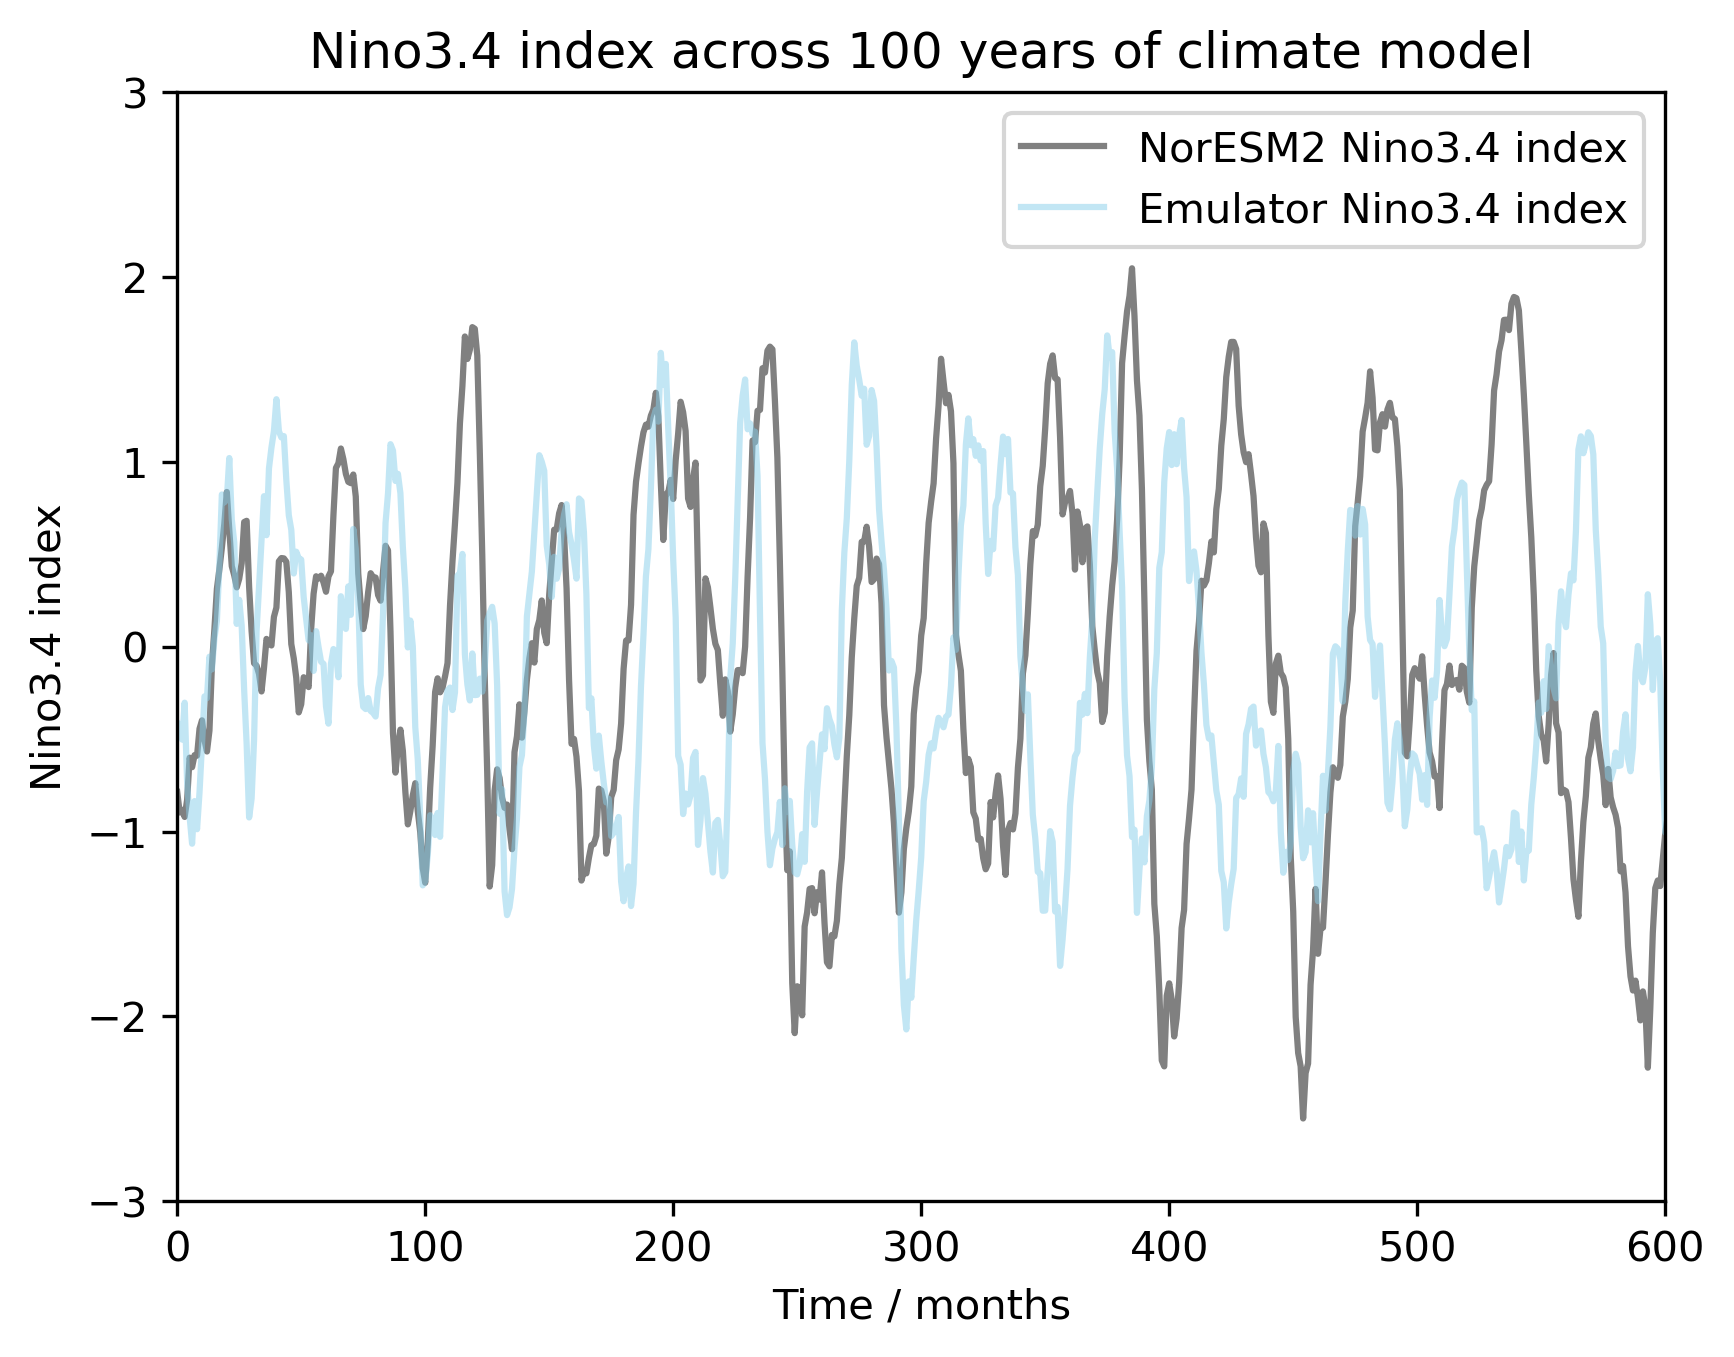

In [99]:
plt.figure(dpi=300)

plt.plot(cmip_dataset_ts_monthed_nino34_mean[0:1200], label='NorESM2 Nino3.4 index', color='gray', alpha = 1.0)
#plt.plot(cmip_dataset_ts_monthed_nino34_mean_rolling[0:500], label='3 month rolling mean')

#plt.plot(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_nino34_mean[:, [5  ], 0], label='Emulator Nino3.4 index', color='skyblue', alpha = 0.5)
#plt.plot(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_nino34_mean[:, [22 ], 0], label='Model Nino3.4 index', color='skyblue', alpha = 0.5)
#plt.plot(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_nino34_mean[:, [98 ], 0], label='Model Nino3.4 index', color='skyblue', alpha = 0.5)
#plt.plot(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_nino34_mean[:, [112 ], 0], label='Model Nino3.4 index', color='skyblue', alpha = 0.5)
#plt.plot(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_nino34_mean[:, [123], 0], label='Model Nino3.4 index', color='skyblue', alpha = 0.5)

plt.plot(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_nino34_mean[:, [5  ], 0], label='Emulator Nino3.4 index', color='skyblue', alpha = 0.5)


plt.ylabel("Nino3.4 index")
plt.xlabel("Time / months")

plt.xlim(0, 600)
plt.ylim(-3, 3)

plt.legend()

plt.title('Nino3.4 index across 100 years of climate model')

# Global mean temperature

In [100]:
print(cmip_dataset_ts_monthed.shape)

# take the mean of this:

cmip_dataset_ts_monthed_mean = cmip_dataset_ts_monthed.mean(axis=2)
#cmip_dataset_ts_monthed_nino34_mean = cmip_dataset_ts_monthed_nino34_mean.reshape(9612, 1, 1)
print(cmip_dataset_ts_monthed_mean.shape)

(6012, 1, 6250)
(6012, 1)


In [101]:
# SELECTING SAMPLE = 23

#sample = 23

#print(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array.shape)
#each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_mean = each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array.mean(axis=3)

#each_timestep_train_array_mean = each_timestep_train_array_mean.reshape(60, 3, 512, 1, 1)
#print(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_mean.shape)

print(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array.shape)
each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_mean = each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array.mean(axis=3)

#each_timestep_train_array_mean = each_timestep_train_array_mean.reshape(60, 3, 512, 1, 1)
print(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array.shape)

(1200, 16, 1, 6250)
(1200, 16, 1, 6250)


Text(0.5, 0, 'Time / months')

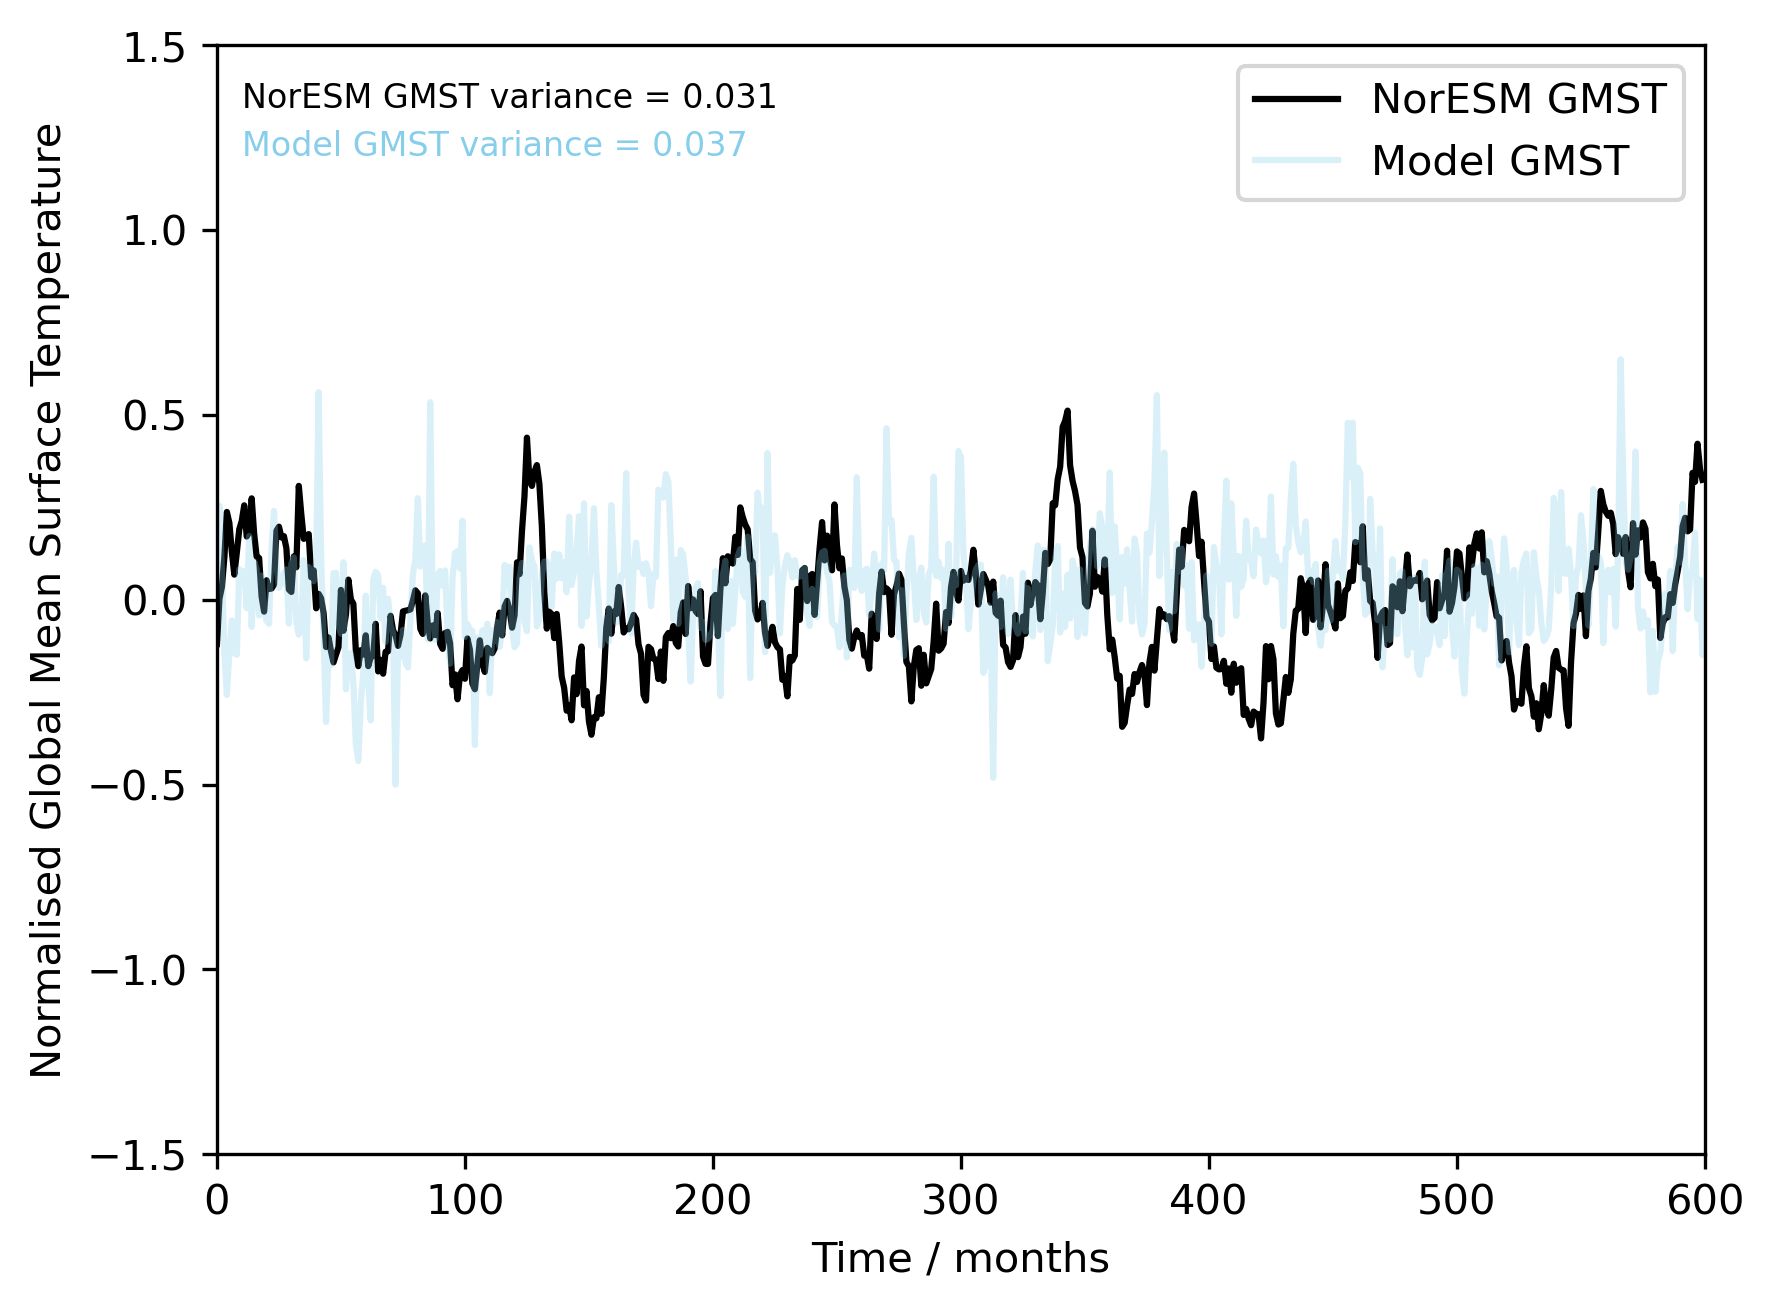

In [104]:
plt.figure(dpi=300)

sample = 23

plt.plot(cmip_dataset_ts_monthed_mean[3200:3800, 0], label='NorESM GMST', color='black', alpha = 1.)
#plt.plot(cmip_dataset_ts_monthed_mean[0:6000, :].reshape(200, 30, 1)[:, (1, 15, 28), 0], label='Raw GMST', color='black', alpha = 0.5)
#plt.plot(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_mean[:, 80, 0], label='Model GMST', color="skyblue", alpha=0.3)
#plt.plot(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_mean[:, [5, 34, 98, 110, 123], 0], label='Model GMST', alpha=0.3)

plt.plot(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_mean[:, 2, 0], label='Model GMST', color="skyblue", alpha=0.3)

plt.xlim(0, 600)
plt.ylim(-1.5,1.5)
#plt.yscale('log')

# add some text to the plot
plt.text(10, 1.33, 'NorESM GMST variance = 0.031', color='black', fontsize=8)
plt.text(10, 1.20, 'Model GMST variance = 0.037', color='skyblue', fontsize=8)


plt.legend()

plt.ylabel("Normalised Global Mean Surface Temperature")
plt.xlabel("Time / months")

In [122]:
# find the samples of each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean that don't have very large absolute values
row_mask = np.all(np.abs(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_mean[0:12000, :, 0]) <= 1.2, axis=0) 

print(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_mean[:, row_mask].shape)

print("Fraction of stable rollouts:", row_mask.mean())
print(173/256)

each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_mean_only_stable = each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_mean[:, row_mask]

(1200, 9, 1)
Fraction of stable rollouts: 0.5625
0.67578125


In [115]:
# what is the variance of the different samples?

# variance:
cmip_dataset_ts_monthed_mean_var = np.var(cmip_dataset_ts_monthed_mean, axis=0)
print(np.median(cmip_dataset_ts_monthed_mean_var))
print(cmip_dataset_ts_monthed_mean_var)

#each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_var = np.var(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean, axis=0)
#print(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_var[(5, 34, 98, 110, 123), :])
print(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_mean_only_stable.shape)
each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_mean_only_stable_var = np.var(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_mean_only_stable, axis=0)
print(np.median(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_mean_only_stable_var[:, :]))
print(np.mean(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_mean_only_stable_var[:, :]))


0.031302605
[0.0313026]
(1200, 9, 1)
0.02770092
0.031102154


In [ ]:
plt.figure(dpi=160)

plt.plot(cmip_dataset_ts_monthed_mean[0:210], label='Raw GMST', color='gray', alpha = 1.0)
plt.plot(cmip_dataset_ts_monthed_mean[210:420], label='Raw GMST', color='gray', alpha = 1.0)
plt.plot(cmip_dataset_ts_monthed_mean[420:630], label='Raw GMST', color='gray', alpha = 1.0)

#plt.plot(cmip_dataset_ts_monthed_mean_rolling[0:500], label='3 month rolling mean')

#plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean[:, [5  ], 0], label='Model GMST', color='skyblue', alpha = 0.3)
plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean[:, [34 ], 0], label='Model GMST', color='skyblue', alpha = 0.3)
plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean[:, [98 ], 0], label='Model GMST', color='skyblue', alpha = 0.3)
plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean[:, [123], 0], label='Model GMST', color='skyblue', alpha = 0.3)

plt.ylabel("GMST")
plt.xlabel("Time / months")

plt.ylim(-1.5,1.5)

plt.title('GMST across 210 months of climate model')

In [ ]:
plt.figure(dpi=160)

plt.plot(cmip_dataset_ts_monthed_mean[0:6000, :].reshape(200, 30, 1).mean(axis=1), label='Raw GMST', color='black', alpha = 0.5)
# fill between the standard deviations
plt.fill_between(range(200), cmip_dataset_ts_monthed_mean[0:6000, :].reshape(200, 30, 1).mean(axis=1).reshape(200), cmip_dataset_ts_monthed_mean[0:6000, :].reshape(200, 30, 1).mean(axis=1).reshape(200) + cmip_dataset_ts_monthed_mean[0:6000, :].reshape(200, 30, 1).std(axis=1).reshape(200), color='gray', alpha=0.5)
plt.fill_between(range(200), cmip_dataset_ts_monthed_mean[0:6000, :].reshape(200, 30, 1).mean(axis=1).reshape(200), cmip_dataset_ts_monthed_mean[0:6000, :].reshape(200, 30, 1).mean(axis=1).reshape(200) - cmip_dataset_ts_monthed_mean[0:6000, :].reshape(200, 30, 1).std(axis=1).reshape(200), color='gray', alpha=0.5)

#plt.plot(cmip_dataset_ts_monthed_mean_rolling[0:500], label='3 month rolling mean')

plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable[:, 0:30, 0].mean(axis=1), label='Model GMST', color='skyblue', alpha = 1.0)
plt.fill_between(range(203), each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable[:, 0:30, 0].mean(axis=1), each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable[:, 0:30, 0].mean(axis=1) + each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable[:, 0:30, 0].std(axis=1), color='skyblue', alpha=0.5)
plt.fill_between(range(203), each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable[:, 0:30, 0].mean(axis=1), each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable[:, 0:30, 0].mean(axis=1) - each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable[:, 0:30, 0].std(axis=1), color='skyblue', alpha=0.5)

plt.ylabel("GMST")
plt.xlabel("Time / months")

plt.ylim(-1.5,1.5)

plt.title('GMST across 210 months of climate model')

# Seasonal cycle of temperature

In [253]:
# Do the same thing for the Nino 3.4 index.
# 5N-5S;170W-120W
# to do this I need to go through the coordinates and find the ones that are closest to the Nino 3.4 index

nhemi = []
for i in range(0, coordinates.shape[0]):
    if coordinates[i, 1] >= 0 and coordinates[i, 1] <= 60:
        nhemi.append(i)

shemi = []
for i in range(0, coordinates.shape[0]):
    if coordinates[i, 1] <= 0 and coordinates[i, 1] >= -60:
        shemi.append(i)

In [254]:
# select just the data from each_timestep_train_array and each_timestep_val_array that corresponds to the Nino 3.4 index

each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_nhemi = each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array[:, :, :, nhemi]
each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_shemi = each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array[:, :, :, shemi]


# do the same for the actual data from the CMIP dataset

cmip_dataset_ts_monthed_nhemi = cmip_dataset_ts_monthed[:, :, nhemi]
cmip_dataset_ts_monthed_shemi = cmip_dataset_ts_monthed[:, :, shemi]

Just check we have selected the right data with a plot.

In [ ]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(8, 6))
plot_preds_icosa_robin(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_nhemi[0, 0, 0, :], coordinates[nhemi, :], ax, 0, '.', True)

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(8, 6))
plot_preds_icosa_robin(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_shemi[0, 0, 0, :], coordinates[shemi, :], ax, 0, '.', True)

#fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(18, 12))
#plot_preds_icosa_robin(cmip_dataset_ts_monthed_nhemi[70, :, :], coordinates[nhemi, :], ax, 0, '.', True)

#fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(18, 12))
#plot_preds_icosa_robin(cmip_dataset_ts_monthed_shemi[70, :, :], coordinates[shemi, :], ax, 0, '.', True)

# I need to take the mean here!

We actually want the three month mean!

In [ ]:
print(cmip_dataset_ts_monthed_nhemi.shape)

# take the mean of this:
cmip_dataset_ts_monthed_nhemi_mean = cmip_dataset_ts_monthed_nhemi.mean(axis=2)
#cmip_dataset_ts_monthed_nhemi_mean = cmip_dataset_ts_monthed_nhemi_mean.reshape(9612, 1, 1)
print(cmip_dataset_ts_monthed_nhemi_mean.shape)

print(cmip_dataset_ts_monthed_shemi.shape)

# take the mean of this:
cmip_dataset_ts_monthed_shemi_mean = cmip_dataset_ts_monthed_shemi.mean(axis=2)
#cmip_dataset_ts_monthed_shemi_mean = cmip_dataset_ts_monthed_shemi_mean.reshape(9612, 1, 1)
print(cmip_dataset_ts_monthed_shemi_mean.shape)

I have to think carefully here about what I should use for indexing, here I just take a random sample.

In [ ]:
print(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_nhemi.shape)
each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_nhemi_mean = each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_nhemi.mean(axis=3)
#each_timestep_train_array_nhemi_mean = each_timestep_train_array_nhemi_mean.reshape(60, 3, 512, 1, 1)
print(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_nhemi_mean.shape)

print(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_shemi.shape)
each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_shemi_mean = each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_shemi.mean(axis=3)
#each_timestep_train_array_shemi_mean = each_timestep_train_array_shemi_mean.reshape(60, 3, 512, 1, 1)
print(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_shemi_mean.shape)

In [ ]:
plt.plot(cmip_dataset_ts_monthed_nhemi_mean[:, 0], label='NorESM northern hemisphere MST', color='black', alpha = 1.0)
#plt.plot(cmip_dataset_ts_monthed_shemi_mean[:, 0], label='NorESM southern hemisphere MST')

plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_nhemi_mean[:, :, 0], label='Model northern hemisphere MST', alpha=0.03)
#plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_shemi_mean[:, :, 0], label='Model southern hemisphere MST')

plt.ylim(-5,5)
plt.xlim(0,60)

#plt.yscale('log')

plt.ylabel("N. Hemisphere MST")
plt.xlabel("Time / months")


plt.title('N. Hemisphere MST across 210 months of climate model')

In [ ]:
#plt.plot(cmip_dataset_ts_monthed_nhemi_mean[:, 0], label='NorESM northern hemisphere MST', color='black', alpha = 1.0)
plt.plot(cmip_dataset_ts_monthed_shemi_mean[:, 0], label='NorESM southern hemisphere MST', color='black', alpha = 1.0)

#plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_nhemi_mean[:, :, 0], label='Model northern hemisphere MST', alpha=0.03)
plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_shemi_mean[:, :, 0], label='Model southern hemisphere MST', alpha=0.03)

plt.ylim(-5,5)
plt.xlim(0,60)

#plt.yscale('log')

plt.ylabel("S. Hemisphere MST")
plt.xlabel("Time / months")


plt.title('S. Hemisphere MST across 210 months of climate model')

In [ ]:
plt.figure(dpi=160)

plt.plot(cmip_dataset_ts_monthed_nhemi_mean[0:210], label='Raw N. hemi MST', color='gray', alpha = 1.0)
#plt.plot(cmip_dataset_ts_monthed_nhemi_mean_rolling[0:500], label='3 month rolling mean')

plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_nhemi_mean[:, [5  ], 0], label='Model N. hemi MST', color='skyblue', alpha = 0.2)
plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_nhemi_mean[:, [34 ], 0], label='Model N. hemi MST', color='skyblue', alpha = 0.2)
plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_nhemi_mean[:, [98 ], 0], label='Model N. hemi MST', color='skyblue', alpha = 0.2)
plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_nhemi_mean[:, [123], 0], label='Model N. hemi MST', color='skyblue', alpha = 0.2)

plt.ylabel("N. hemi MST")
plt.xlabel("Time / months")

plt.title('N. hemi MST across 210 months of climate model')

In [ ]:
plt.figure(dpi=160)

plt.plot(cmip_dataset_ts_monthed_shemi_mean[0:210], label='Raw S. hemi MST', color='gray', alpha = 1.0)
plt.plot(cmip_dataset_ts_monthed_shemi_mean[210:420], label='Raw S. hemi MST', color='gray', alpha = 1.0)

#plt.plot(cmip_dataset_ts_monthed_shemi_mean_rolling[0:500], label='3 month rolling mean')

plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_shemi_mean[:, [5  ], 0], label='Model S. hemi MST', color='skyblue', alpha = 0.2)
plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_shemi_mean[:, [34 ], 0], label='Model S. hemi MST', color='skyblue', alpha = 0.2)
plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_shemi_mean[:, [98 ], 0], label='Model S. hemi MST', color='skyblue', alpha = 0.2)
plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_shemi_mean[:, [123], 0], label='Model S. hemi MST', color='skyblue', alpha = 0.2)

plt.ylabel("S. hemi MST")
plt.xlabel("Time / months")

plt.title('S. hemi MST across 210 months of climate model')

Calculate if there is a mean bias.

In [ ]:
# find the samples of each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean that don't have very large absolute values
row_mask = np.all(np.abs(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean[:, :, 0]) <= 0.9, axis=0) 

print(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean[:, row_mask].shape)

print("Fraction of stable rollouts:", row_mask.mean())
print(173/256)

each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable = each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean[:, row_mask]

In [269]:
# select just the data from each_timestep_train_array and each_timestep_val_array that corresponds to the Nino 3.4 index

each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_nhemi = each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array[:, row_mask][:, :, :, nhemi]
each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_shemi = each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array[:, row_mask][:, :, :, shemi]


In [ ]:
cmip_dataset_ts_monthed_nhemi[0:6000].shape, each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_nhemi.shape

In [ ]:
each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_nhemi.shape

In [ ]:
np.random.randint(0, 102, size=30)

In [431]:
# take the average nhemi and shemi temp
each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_nhemi_thrutime_mean = each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_nhemi.mean(axis=(1, 2, 3))
each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_shemi_thrutime_mean = each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_shemi.mean(axis=(1, 2, 3))

each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_nhemi_stacked30thrutime_mean = each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_nhemi[:, np.random.randint(0, 102, size=30), :, :].mean(axis=(1, 2, 3))
each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_shemi_stacked30thrutime_mean = each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_shemi[:, np.random.randint(0, 102, size=30), :, :].mean(axis=(1, 2, 3))

each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_nhemi_time_mean = each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_nhemi.mean(axis=(0, 1, 2, 3))
each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_shemi_time_mean = each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_shemi.mean(axis=(0, 1, 2, 3))

# take the average of the climate model temps

cmip_dataset_ts_monthed_nhemi_thrutime_mean = cmip_dataset_ts_monthed_nhemi.mean(axis=(1, 2))
cmip_dataset_ts_monthed_shemi_thrutime_mean = cmip_dataset_ts_monthed_shemi.mean(axis=(1, 2))

cmip_dataset_ts_monthed_nhemi_stackedthrutime_mean = cmip_dataset_ts_monthed_nhemi[0:6000].reshape(200, 30, 1, -1).mean(axis=(1, 2, 3))
cmip_dataset_ts_monthed_shemi_stackedthrutime_mean = cmip_dataset_ts_monthed_shemi[0:6000].reshape(200, 30, 1, -1).mean(axis=(1, 2, 3))

cmip_dataset_ts_monthed_nhemi_time_mean = cmip_dataset_ts_monthed_nhemi.mean(axis=(0, 1, 2))
cmip_dataset_ts_monthed_shemi_time_mean = cmip_dataset_ts_monthed_shemi.mean(axis=(0, 1, 2))

In [ ]:
print("Obs n. hemi mean temp", cmip_dataset_ts_monthed_nhemi_time_mean)
print("Obs s. hemi mean temp", cmip_dataset_ts_monthed_shemi_time_mean)

print("Model n. hemi mean temp", each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_nhemi_time_mean)
print("Model s. hemi mean temp", each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_shemi_time_mean)

In [ ]:
#plt.plot(cmip_dataset_ts_monthed_nhemi_thrutime_mean, label='Obs northern hemisphere MST', color='black', alpha = 1.0)
#plt.plot(cmip_dataset_ts_monthed_shemi_thrutime_mean, label='Obs southern hemisphere MST', color='black', alpha = 1.0)

plt.plot(cmip_dataset_ts_monthed_nhemi_stackedthrutime_mean, label='Obs northern hemisphere MST', color='black', alpha = 1.0)
#plt.plot(cmip_dataset_ts_monthed_shemi_stackedthrutime_mean, label='Obs southern hemisphere MST', color='black', alpha = 1.0)

#plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_nhemi_thrutime_mean, label='Model northern hemisphere MST', alpha=0.5)
#plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_shemi_thrutime_mean, label='Model southern hemisphere MST', alpha=0.5)

plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_nhemi_stacked30thrutime_mean, label='Model northern hemisphere MST', alpha=0.5)
#plt.plot(each_timestep_pfspec_300_samples_50_years_finalvae_picontrol_array_mean_only_stable_shemi_stacked30thrutime_mean, label='Model southern hemisphere MST', alpha=0.5)

plt.ylim(-2,2)
plt.xlim(0,200)

# Calculate the average annual temperature range

In [107]:
# Calculate and plot the average annual temperature range
cmip_dataset_ts_monthed.reshape(501, 12, 1, -1).shape
# for each year calculate the range of temperatures
cmip_dataset_ts_monthed_yearly_range = cmip_dataset_ts_monthed.reshape(501, 12, 1, -1).max(axis=1) - cmip_dataset_ts_monthed.reshape(501, 12, 1, -1).min(axis=1)
# are all the values positive?
assert (cmip_dataset_ts_monthed_yearly_range >= 0).all() == True
print("Max value:", cmip_dataset_ts_monthed_yearly_range.max())
print(cmip_dataset_ts_monthed_yearly_range.shape)
# take the mean over all the years
cmip_dataset_ts_monthed_yearly_range_mean = cmip_dataset_ts_monthed_yearly_range.mean(axis=0)
print("Range max value:", cmip_dataset_ts_monthed_yearly_range_mean.max())
print("Range min value:", cmip_dataset_ts_monthed_yearly_range_mean.min())
print(cmip_dataset_ts_monthed_yearly_range_mean.shape)

# calculate the standard deviation across all the years
cmip_dataset_ts_monthed_yearly_range_std = cmip_dataset_ts_monthed_yearly_range.std(axis=0)
print("Std max value:", cmip_dataset_ts_monthed_yearly_range_std.max())
print("Std min value:", cmip_dataset_ts_monthed_yearly_range_std.min())
print(cmip_dataset_ts_monthed_yearly_range_std.shape)

Max value: 15.198772
(501, 1, 6250)
Range max value: 3.2500594
Range min value: 1.199561
(1, 6250)
Std max value: 1.3635608
Std min value: 0.42383608
(1, 6250)


In [89]:
each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable = each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array[:, row_mask]


In [90]:
each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable.shape

(1200, 62, 1, 6250)

In [94]:
each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable[0:600].reshape(50, 12, 62, 1, -1).shape
# for each year calculate the range of temperatures
each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range = each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable[0:600].reshape(50, 12, 62, 1, -1).max(axis=1) - each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable[0:600].reshape(50, 12, 62, 1, -1).min(axis=1)
print("Shape of yearly range:", each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range.shape)
# are all the values positive?
assert (each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range >= 0).all() == True

# take the mean over all the years
each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_mean = each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range.mean(axis=0)
print("Max value:", each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_mean.max())
print("Min value:", each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_mean.min())
print(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_mean.shape)

# calculate the standard deviation across all the years
each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_std = each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range.std(axis=0)
print("Std max value:", each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_std.max())
print("Std min value:", each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_std.min())
print(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_std.shape)

# take the mean over all the samples
each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_mean_sample_mean = each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_mean.mean(axis=0)
print("Max value:", each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_mean_sample_mean.max())
print("Min value:", each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_mean_sample_mean.min())
print(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_mean_sample_mean.shape)

# take the mean of the standard deviation over all the samples
each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_std_sample_mean = each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_std.mean(axis=0)
print("Std mean max value:", each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_std_sample_mean.max())
print("Std mean min value:", each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_std_sample_mean.min())
print(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_std_sample_mean.shape)



Shape of yearly range: (50, 62, 1, 6250)
Max value: 5.117624
Min value: 0.55833954
(62, 1, 6250)
Std max value: 3.351732
Std min value: 0.11888533
(62, 1, 6250)
Max value: 4.0271277
Min value: 0.6387011
(1, 6250)
Std mean max value: 1.5674667
Std mean min value: 0.19496633
(1, 6250)


In [118]:
33750000 / (100 * 12 * 6250)

4.5

In [120]:
each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable.shape

(1200, 9, 1, 6250)

In [125]:
each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable = each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array[:, row_mask]


each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable.reshape(100, 12, 9, 1, -1).shape
# for each year calculate the range of temperatures
each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range = each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable.reshape(100, 12, 9, 1, -1).max(axis=1) - each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable.reshape(100, 12, 9, 1, -1).min(axis=1)
print("Shape of yearly range:", each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range.shape)
# are all the values positive?
assert (each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range >= 0).all() == True

# take the mean over all the years
each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_mean = each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range.mean(axis=0)
print("Max value:", each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_mean.max())
print("Min value:", each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_mean.min())
print(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_mean.shape)

# calculate the standard deviation across all the years
each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_std = each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range.std(axis=0)
print("Std max value:", each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_std.max())
print("Std min value:", each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_std.min())
print(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_std.shape)

# take the mean over all the samples
each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_mean_sample_mean = each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_mean.mean(axis=0)
print("Max value:", each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_mean_sample_mean.max())
print("Min value:", each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_mean_sample_mean.min())
print(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_mean_sample_mean.shape)

# take the mean of the standard deviation over all the samples
each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_std_sample_mean = each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_std.mean(axis=0)
print("Std mean max value:", each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_std_sample_mean.max())
print("Std mean min value:", each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_std_sample_mean.min())
print(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_std_sample_mean.shape)



Shape of yearly range: (100, 9, 1, 6250)
Max value: 4.547734
Min value: 0.5689669
(9, 1, 6250)
Std max value: 1.7535095
Std min value: 0.15712121
(9, 1, 6250)
Max value: 3.8942473
Min value: 0.6234233
(1, 6250)
Std mean max value: 1.4609388
Std mean min value: 0.1802204
(1, 6250)


In [128]:
# Plotting functions for videos of the rollouts.

def plot_preds_icosa_robin_range(data, coordinates, axs, timestep, out_dir, show_plot=True):

    axs.set_global()
    axs.coastlines()
    # Add some map features for context
    axs.add_feature(cfeature.BORDERS, linestyle=':')
    axs.add_feature(cfeature.COASTLINE)
    axs.add_feature(cfeature.LAND, edgecolor='black')
    axs.gridlines(draw_labels=False)

    # Unpack coordinates for vectorized scatter plot
    x = coordinates[:, 0]
    y = coordinates[:, 1]

    # Vectorized scatter plot with color array
    s = axs.scatter(x=x, y=y, c=data, alpha=1, s=30, vmin=0.6, vmax=3.9, cmap="viridis", transform=ccrs.PlateCarree())  # Store scatter plot object

    # add a colorbar
    plt.colorbar(s, ax=axs, label="Normalised temperature range", orientation="vertical", shrink=1.0) # adjust shrink
    #axs.colorbar(s, ax=axs, label="Normalised slp", orientation="vertical", shrink=1.0) # adjust shrink

    # add a title
    #plt.title(f"")
    
    fname = f"{out_dir}/just_icosa_pred_timestep_{timestep}.png"
    plt.suptitle("Comparison of annual range of temperature anomalies between NorESM and emulator", fontsize=16)    
    plt.savefig(fname)

    if show_plot == False:
        plt.close()

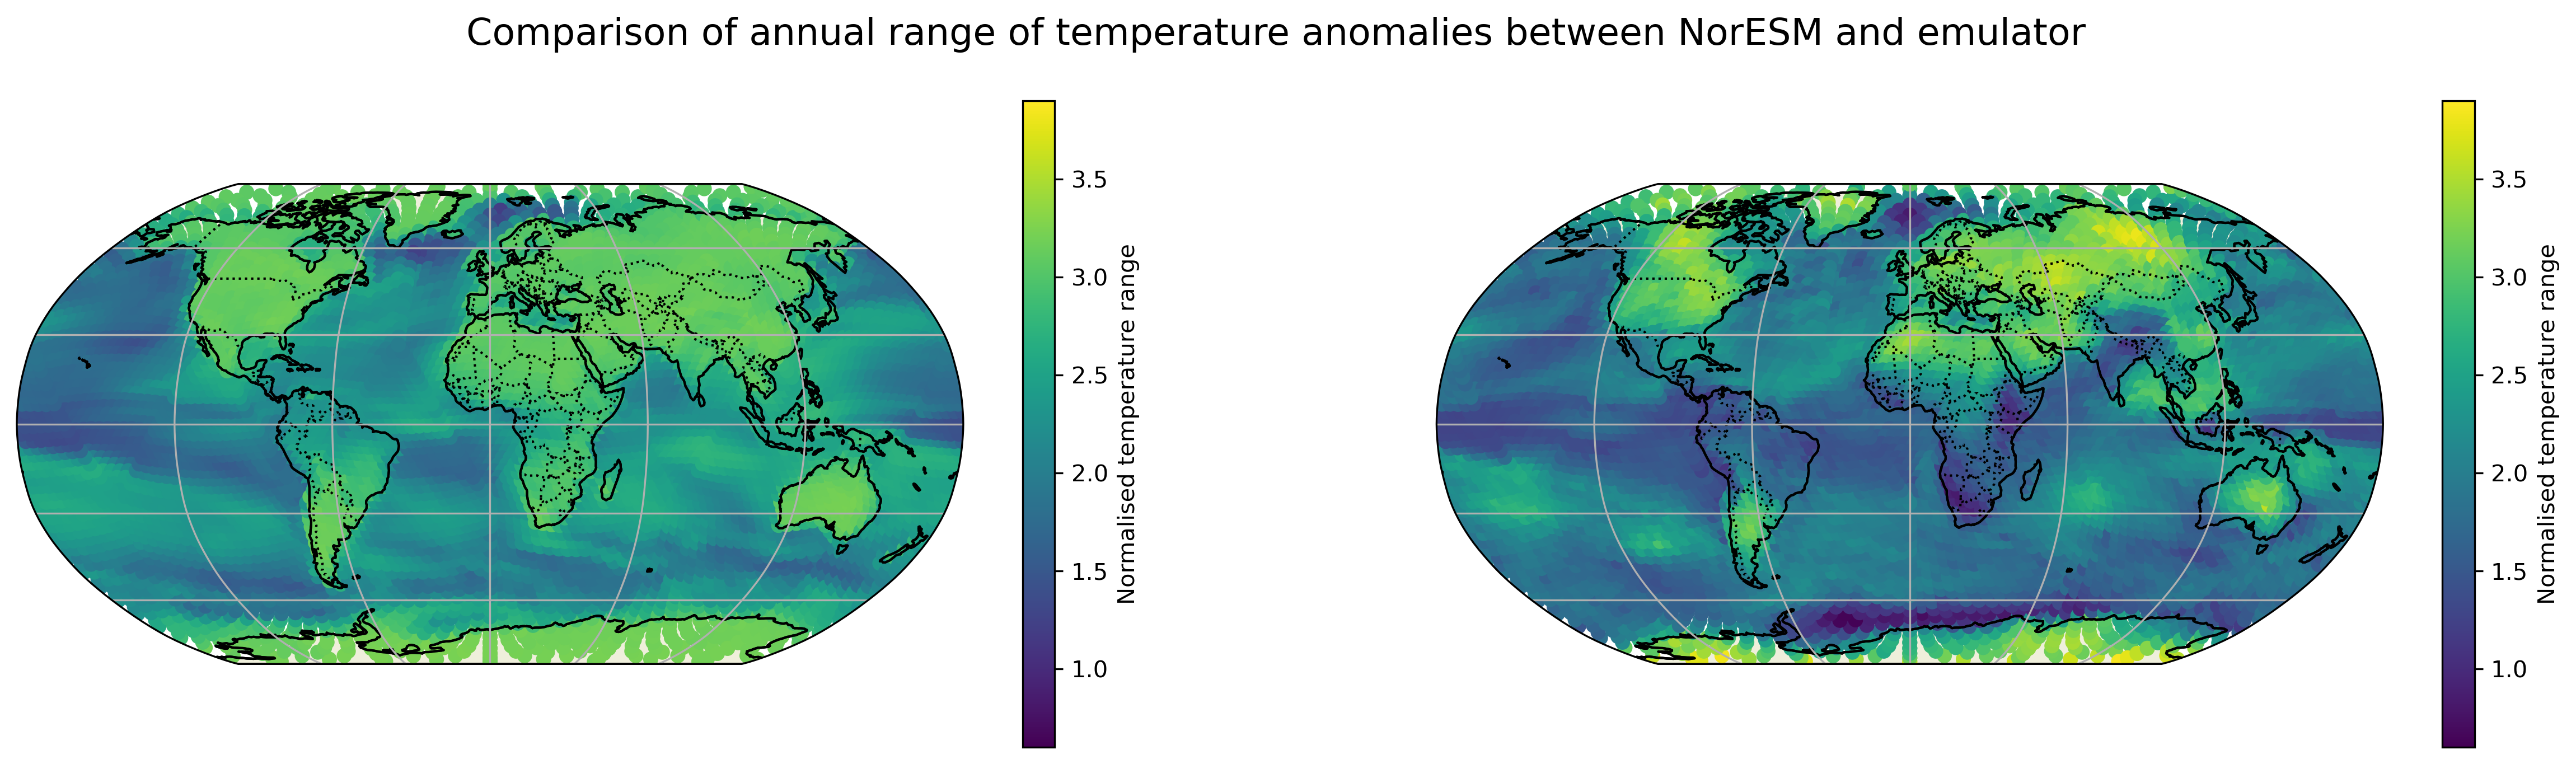

In [129]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.Robinson()}, figsize=(20, 5), dpi=300)
plot_preds_icosa_robin_range(cmip_dataset_ts_monthed_yearly_range_mean[0, :], coordinates[:, :], ax[0], 0, '.', True)

#fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(8, 6))
#plot_preds_icosa_robin_range(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_mean_sample_mean[0, :], coordinates[:, :], ax[1], 0, '.', True)
plot_preds_icosa_robin_range(each_timestep_pfspecclip_20000_samples_100_years_16_batch_finalvae_picontrol_array_stable_yearly_range_mean_sample_mean[0, :], coordinates[:, :], ax[1], 0, '.', True)



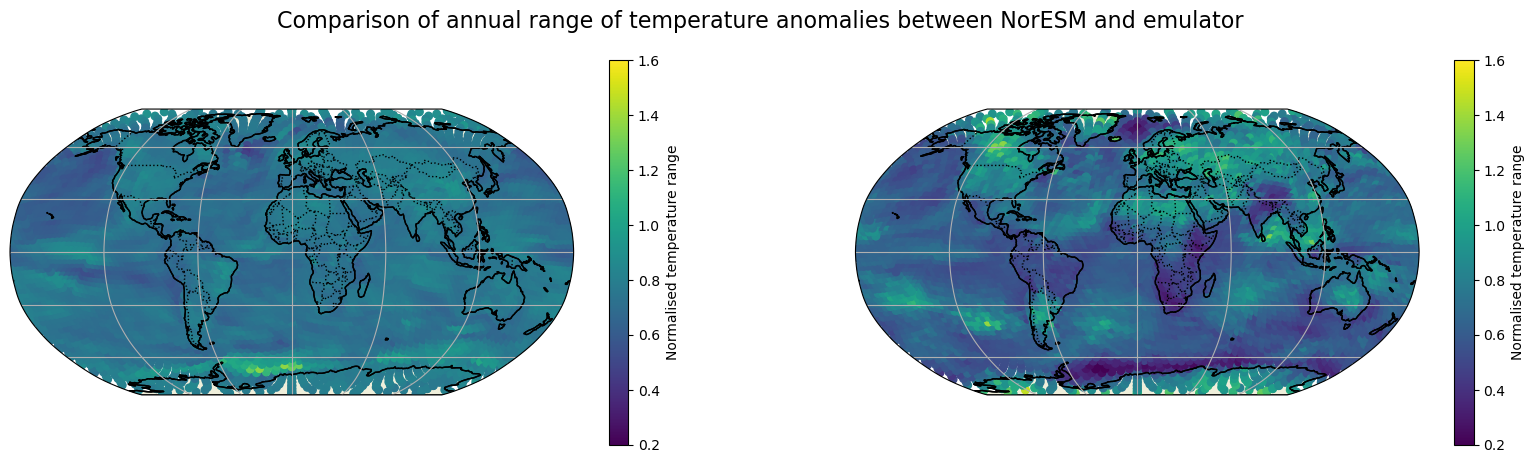

In [104]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.Robinson()}, figsize=(20, 5))
plot_preds_icosa_robin_range(cmip_dataset_ts_monthed_yearly_range_std[0, :], coordinates[:, :], ax[0], 0, '.', True)

#fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(8, 6))
plot_preds_icosa_robin_range(each_timestep_pfspecclip_2500_samples_100_years_finalvae_picontrol_array_stable_yearly_range_std_sample_mean[0, :], coordinates[:, :], ax[1], 0, '.', True)



# Calculate return periods of very high temperatures?

Spare ENSO code.

In [ ]:
plt.plot(each_timestep_train_array_nino34_mean[0:60, 1, 12, 0], label='Model Nino3.4 index')
plt.plot(each_timestep_train_array_nino34_mean_rolling[0:60, 12], label='3 month rolling mean')

In [ ]:
# NOTE, now the rolling mean of the 0, 1, 2 elements are in position 2!

In [ ]:
each_timestep_array_rolling_mean.shape

In [119]:
each_timestep_train_array_nino34_mean_rolling[0, :] = each_timestep_train_array_nino34_mean[0, 1, :, 0]
each_timestep_train_array_nino34_mean_rolling[1, :] = each_timestep_train_array_nino34_mean[1, 1, :, 0]

In [ ]:
each_timestep_train_array_nino34_mean_rolling

In [ ]:
rolling_pearsons, rolling_pearsons_persistence = calculate_pearsons_ar_cmip_rolling_mean_nino34(each_timestep_train_array_nino34_mean_rolling, cmip_dataset_ts_monthed_nino34_mean_rolling, list_of_indices_model, list_of_indices_cmip, 120)

In [ ]:
print(stats.pearsonr(each_timestep_train_array_nino34_mean[20, 1, list_of_indices_model, 0].flatten(), cmip_dataset_ts_monthed_nino34_mean[[x+20 for x in list_of_indices_cmip], 0]))
print(stats.pearsonr(each_timestep_train_array_nino34_mean_rolling[20, list_of_indices_model].flatten(), cmip_dataset_ts_monthed_nino34_mean_rolling[[x+20 for x in list_of_indices_cmip], 0]))

print(stats.pearsonr(each_timestep_train_array_nino34_mean[30, 1, list_of_indices_model, 0].flatten(), cmip_dataset_ts_monthed_nino34_mean[[x+30 for x in list_of_indices_cmip], 0]))
print(stats.pearsonr(each_timestep_train_array_nino34_mean_rolling[30, list_of_indices_model].flatten(), cmip_dataset_ts_monthed_nino34_mean_rolling[[x+30 for x in list_of_indices_cmip], 0]))

print(stats.pearsonr(each_timestep_train_array_nino34_mean[4, 1, list_of_indices_model, 0].flatten(), cmip_dataset_ts_monthed_nino34_mean[[x+4 for x in list_of_indices_cmip], 0]))
print(stats.pearsonr(each_timestep_train_array_nino34_mean_rolling[4, list_of_indices_model].flatten(), cmip_dataset_ts_monthed_nino34_mean_rolling[[x+4 for x in list_of_indices_cmip], 0]))

print(stats.pearsonr(each_timestep_train_array_nino34_mean[2, 1, list_of_indices_model, 0].flatten(), cmip_dataset_ts_monthed_nino34_mean[[x+2 for x in list_of_indices_cmip], 0]))
print(stats.pearsonr(each_timestep_train_array_nino34_mean_rolling[2, list_of_indices_model].flatten(), cmip_dataset_ts_monthed_nino34_mean_rolling[[x+2 for x in list_of_indices_cmip], 0]))

In [ ]:
train_pearsons, train_pearsons_persistence = calculate_pearsons_ar_cmip(each_timestep_train_array, cmip_dataset_ts_monthed, list_of_indices, 120)
#train_pearsons_150, train_pearsons_150_persistence = calculate_pearsons_ar_cmip(each_timestep_train_array_150, cmip_dataset_ts_monthed, list_of_indices, 60)

train_pearsons_nino34, train_pearsons_persistence_nino34 = calculate_pearsons_ar_cmip_mean_nino34(each_timestep_train_array_nino34_mean, cmip_dataset_ts_monthed_nino34_mean, list_of_indices, 120)
#train_pearsons_150_nino34, train_pearsons_150_persistence_nino34 = calculate_pearsons_ar_cmip(each_timestep_train_array_150_nino34, cmip_dataset_ts_monthed_nino34, list_of_indices, 60)


In [ ]:
train_pearsons, train_pearsons_persistence = calculate_pearsons_ar_cmip(each_timestep_train_array, cmip_dataset_ts_monthed, list_of_indices, 60)
#train_pearsons_150, train_pearsons_150_persistence = calculate_pearsons_ar_cmip(each_timestep_train_array_150, cmip_dataset_ts_monthed, list_of_indices, 60)

train_pearsons_nino34, train_pearsons_persistence_nino34 = calculate_pearsons_ar_cmip(each_timestep_train_array_nino34, cmip_dataset_ts_monthed_nino34.mean(axis=2), list_of_indices, 60)
#train_pearsons_150_nino34, train_pearsons_150_persistence_nino34 = calculate_pearsons_ar_cmip(each_timestep_train_array_150_nino34, cmip_dataset_ts_monthed_nino34, list_of_indices, 60)

# repeat for the validation data

#val_pearsons, val_pearsons_persistence = calculate_pearsons_ar_cmip(each_timestep_val_array, cmip_dataset_ts_monthed, list_of_indices_val, 60)
#val_pearsons_150, val_pearsons_150_persistence = calculate_pearsons_ar_cmip(each_timestep_val_array_150, cmip_dataset_ts_monthed, list_of_indices_val, 60)

#val_pearsons_nino34, val_pearsons_persistence_nino34 = calculate_pearsons_ar_cmip(each_timestep_val_array_nino34, cmip_dataset_ts_monthed_nino34.mean(axis=2), list_of_indices_val, 60)
#val_pearsons_150_nino34, val_pearsons_150_persistence_nino34 = calculate_pearsons_ar_cmip(each_timestep_val_array_150_nino34, cmip_dataset_ts_monthed_nino34, list_of_indices_val, 60)

In [ ]:
plt.plot(train_pearsons.mean(axis=0), label='Model 120, global')
plt.plot(train_pearsons_persistence.mean(axis=0), label='Persistence, global')

#plt.plot(train_pearsons_150.mean(axis=0), label='Model, global')
#plt.plot(train_pearsons_150_persistence.mean(axis=0), label='Persistence, global')

plt.plot(train_pearsons_nino34.mean(axis=0), label='Model 120, Nino34')
plt.plot(train_pearsons_persistence_nino34.mean(axis=0), label='Persistence, Nino34')

#plt.plot(train_pearsons_150_nino34.mean(axis=0), label='Model, Nino34')
#plt.plot(train_pearsons_150_persistence_nino34.mean(axis=0), label='Persistence, Nino34')


plt.legend()
plt.title('Anomaly correlation coefficient')
plt.xlabel('Timestep / months')
plt.ylabel('Anomaly correlation coefficient')

plt.xlim(-1, 24)

In [ ]:
plt.plot(rolling_pearsons, label='Model, Nino34')
plt.plot(rolling_pearsons_persistence, label='Persistence, Nino34')

plt.legend()
plt.title('Anomaly correlation coefficient')
plt.xlabel('Timestep / months')
plt.ylabel('Anomaly correlation coefficient')

plt.xlim(-1, 120)

# Leftovers.

In [ ]:
# calculate the spatial spectra of the particle filtered rollout and the novae rollout


fft_true = torch.mean(torch.abs(torch.fft.rfft(y[:, :, :], dim=2)), dim=0)
# calculate the average spatial spectra of the individual predicted fields - I think this below is wrong
#print("y_pred pf shape:", each_timestep_pf_array.shape)
#print("y_pred novae shape:", each_timestep_novae_array.shape)

fft_pred = torch.mean(torch.abs(torch.fft.rfft(torch.Tensor(each_timestep_novae_array[:, 1, :, :, :]), dim=3)), dim=1)
fft_pred_pf = torch.mean(torch.abs(torch.fft.rfft(torch.Tensor(each_timestep_pf_array[:, 0, :, :, :]), dim=3)), dim=1)

# extend fft_true so it is the same value but extended to the same shape as fft_pred
fft_true = fft_true.repeat(120, 1, 1)

# assert that the first two elements of fft_true are the same
assert torch.allclose(fft_true[0, :, :], fft_true[1, :, :])

#print("fft_true shape after repeating:", fft_true.shape)
#print("fft_pred shape:", fft_pred.shape)

# calculate the difference between the true and predicted spatial spectra
spatial_spectra_score = torch.abs(fft_pred - fft_true)
spatial_spectra_score_pf = torch.abs(fft_pred_pf - fft_true)

print("Spatial spectra score raw from the fft:", spatial_spectra_score.shape)

# take the mean of the spatial spectra score across the variables and the wavenumbers, the final 2 axes
spatial_spectra_score = torch.mean(spatial_spectra_score, dim=(1, 2))
spatial_spectra_score_pf = torch.mean(spatial_spectra_score_pf, dim=(1, 2))


print('Lower is better')

#print("Spatial spectra score meaned:", spatial_spectra_score)
#print("Spatial spectra score meaned pf:", spatial_spectra_score_pf)

print("Raw - pf, if positive then pf is better:", spatial_spectra_score - spatial_spectra_score_pf)